# Generative Models

## GANs & VAE

### HW6

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [2]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Projects/HM6/"


Mounted at /content/drive


In [3]:
data_path = "/content/"

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [4]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [5]:
# Download dataset
mnist_data = datasets.MNIST(
    root=data_path,        # The path where the data will be stored
    train=True,            # We want the training set (60,000 images)
    download=True,         # Download it if not already present in the 'root' directory
    transform=transformation # Apply the transformation
)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.33MB/s]


In [6]:
num_threads = 4
batch_size = 64

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,          # Shuffle the data at the beginning of each epoch
    num_workers=num_threads
)

val_loader = DataLoader(
    dataset=valid_data,
    batch_size=batch_size,
    shuffle=False,         # No need to shuffle validation data
    num_workers=num_threads
)
print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")

Train DataLoader created with 782 batches.
Validation DataLoader created with 157 batches.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers. Use above diagram.
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_log_var = nn.Linear(hidden_dim, latent_dim)
        ##########################################################


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        h = F.relu(self.FC_input(x))
        # Get the mean and log-variance from the hidden layer
        z_mean = self.FC_mean(h)
        z_log_var = self.FC_log_var(h)
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        ##############################

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        # Pass the latent vector through the hidden layer and apply ReLU
        h = F.relu(self.FC_hidden(z))
        # to get pixel values between 0 and 1
        x = torch.sigmoid(self.FC_output(h))
        ########################################

        return x

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        # 1. Encode the input image to get the mean and log-variance of the latent distribution
        z_mean, z_log_var = self.encoder(x)
        # 2. Reparameterization Trick: z = mu + sigma * epsilon
        #    - Sample epsilon from a standard normal distribution
        #    - Calculate standard deviation (sigma) from log-variance (log_var)
        #    - This allows gradients to flow back through the sampling process
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std) # Sample from N(0, I) with the same shape as std
        z = z_mean + eps * std

        image = self.decoder(z)
        ##########################################################

        return image, z_mean, z_log_var

In [9]:
def reconstruct_images(vae, images):
    images = images.view(-1, 784).to(DEVICE)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images.view(-1, 1, 28, 28)

def plot_images(original, reconstructed, n=4):
    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    plt.show()

In [10]:
def loss_function(x_hat, x, mean, log_var):
    """Elbo loss function."""
    # Reconstruction loss: measures how well the decoder reconstructs the input
    # Using Binary Cross Entropy since pixel values are between 0 and 1
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")

    # KL Divergence: a regularizer that forces the latent space to be close to a standard normal distribution
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + kld

def train_vae(dataloader, val_loader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim)
    model = model.to(DEVICE)
    criterion = loss_function # The provided ELBO loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Get a fixed batch of validation images to monitor reconstruction progress
    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        print(f'Epoch {epoch+1}: ')
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.

                x, _ = data
                x = x.view(x.size(0), -1).to(DEVICE)

                optimizer.zero_grad()
                x_hat, mean, log_var = model(x)

                loss = criterion(x_hat, x, mean, log_var)
                loss.backward()

                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(dataloader.dataset)
            print('Train Loss: {:.4f}'.format(avg_train_loss))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        with torch.no_grad():
            model.eval() #
            recon_images = reconstruct_images(model, sample_images)
            plot_images(sample_images, recon_images)

            val_loss = 0
            with tqdm(enumerate(val_loader), total=len(val_loader),desc="Validation") as pbar:
              for i, data in pbar:
                    x, _ = data
                    x = x.view(x.size(0), -1).to(DEVICE)
                    x_hat, mean, log_var = model(x)
                    loss = criterion(x_hat, x, mean, log_var)
                    val_loss += loss.item()

              avg_val_loss = val_loss / len(val_loader.dataset)
              print('Val Loss: {:.4f}'.format(avg_val_loss))
              val_losses.append(avg_val_loss)


        # Sample From Latent Space
        if epoch % 10 == 0:
          with torch.no_grad():
                model.eval()
                # Sample random z vectors from the prior (standard normal)
                z = torch.randn(64, latent_dim).to(DEVICE)
                # Decode the random vectors to generate new images
                samples = model.decoder(z)
                # Reshape to image format
                samples = samples.view(-1, 1, 28, 28)
                # Create a grid for visualization
                grid_img = torchvision.utils.make_grid(samples, nrow=8)
                plt.figure(figsize=(10, 10))
                plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
                plt.title(f"Generated Samples at Epoch {epoch+1}")
                plt.axis('off')
                plt.show()

    return model, val_losses

Epoch 1: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 250.7276


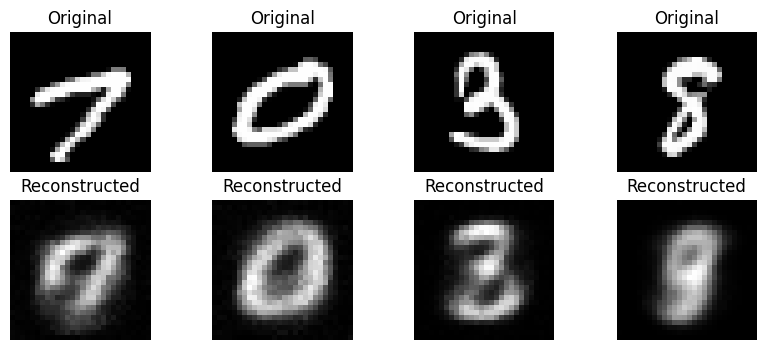

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 190.4766


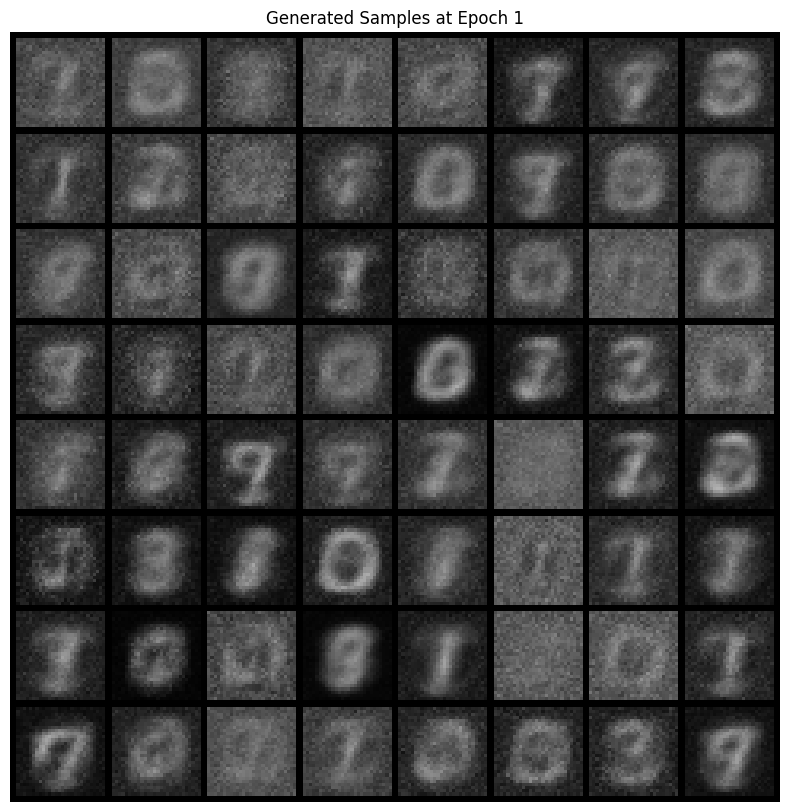

Epoch 2: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 172.3395


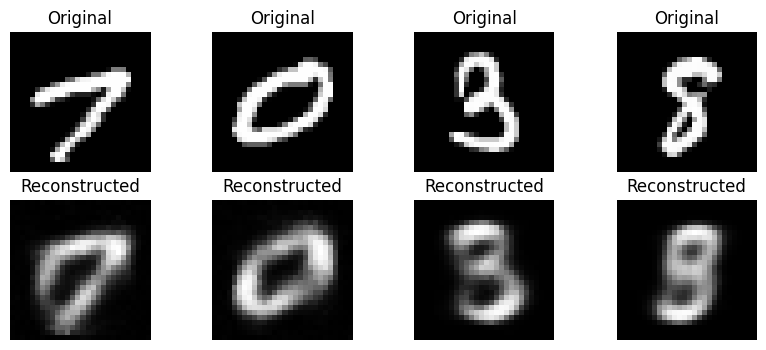

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 159.7047
Epoch 3: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 152.6658


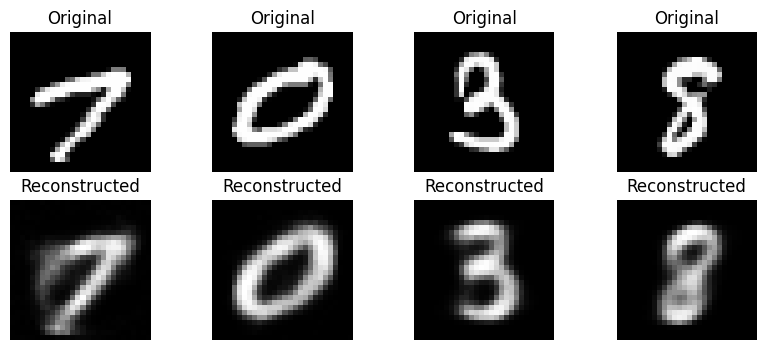

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 147.0120
Epoch 4: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 143.3428


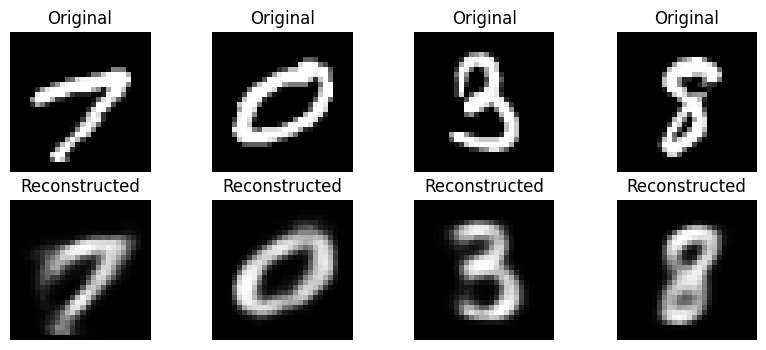

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 139.7533
Epoch 5: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 137.1175


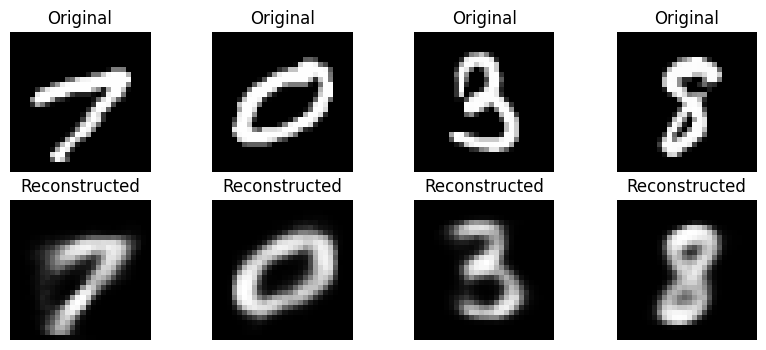

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 134.7732
Epoch 6: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 133.0965


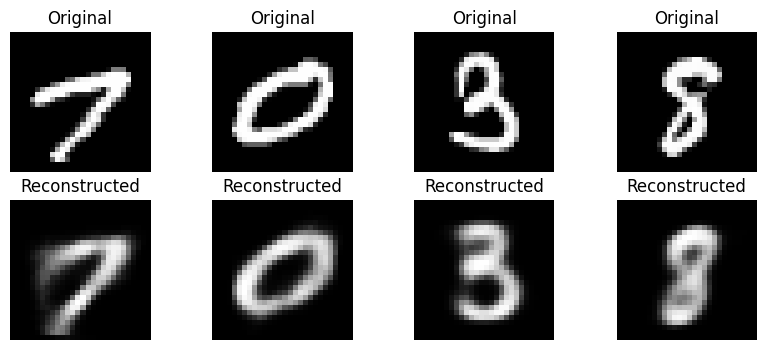

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 131.6170
Epoch 7: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 130.3933


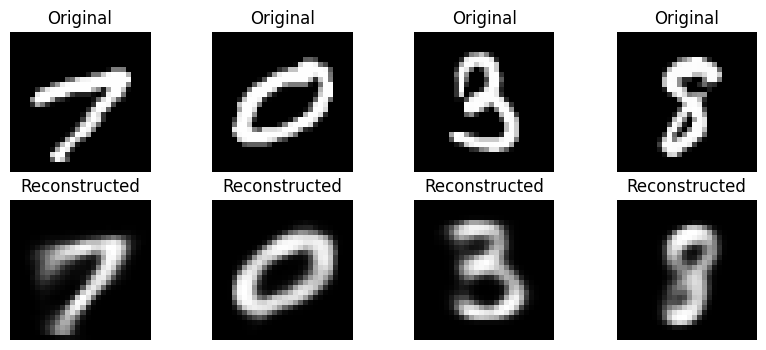

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 129.3484
Epoch 8: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 128.3322


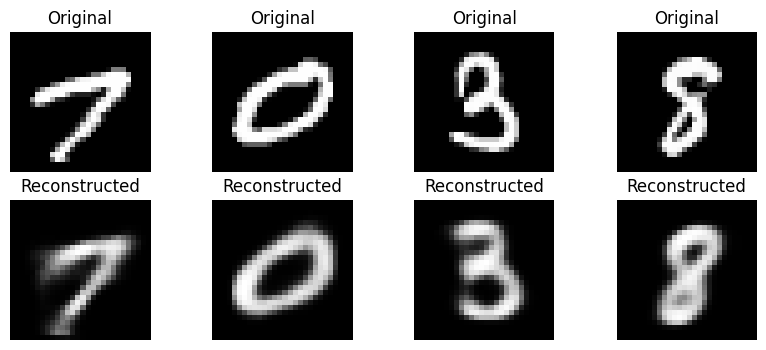

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 127.5756
Epoch 9: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 126.7050


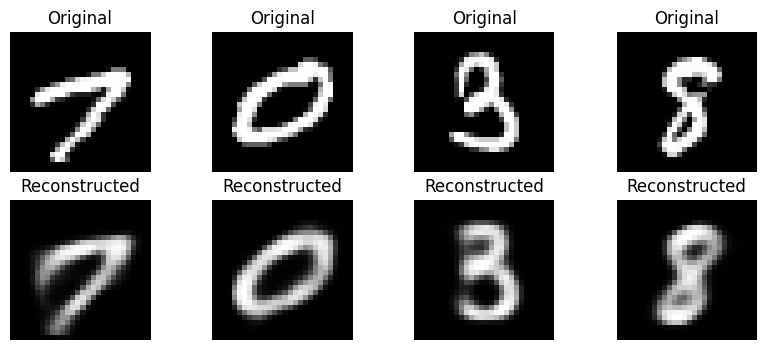

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 126.1360
Epoch 10: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 125.3135


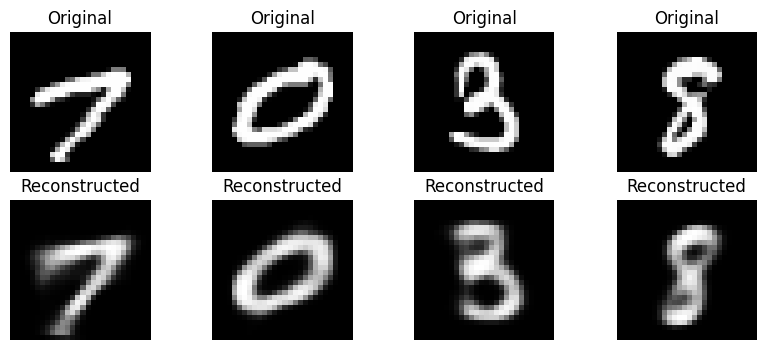

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 124.9875
Epoch 11: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 124.1436


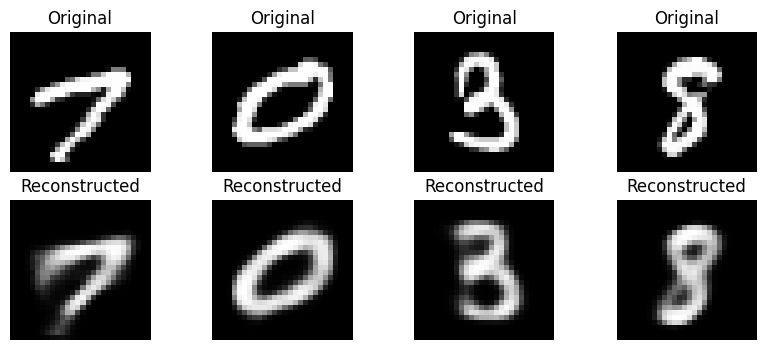

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 123.8036


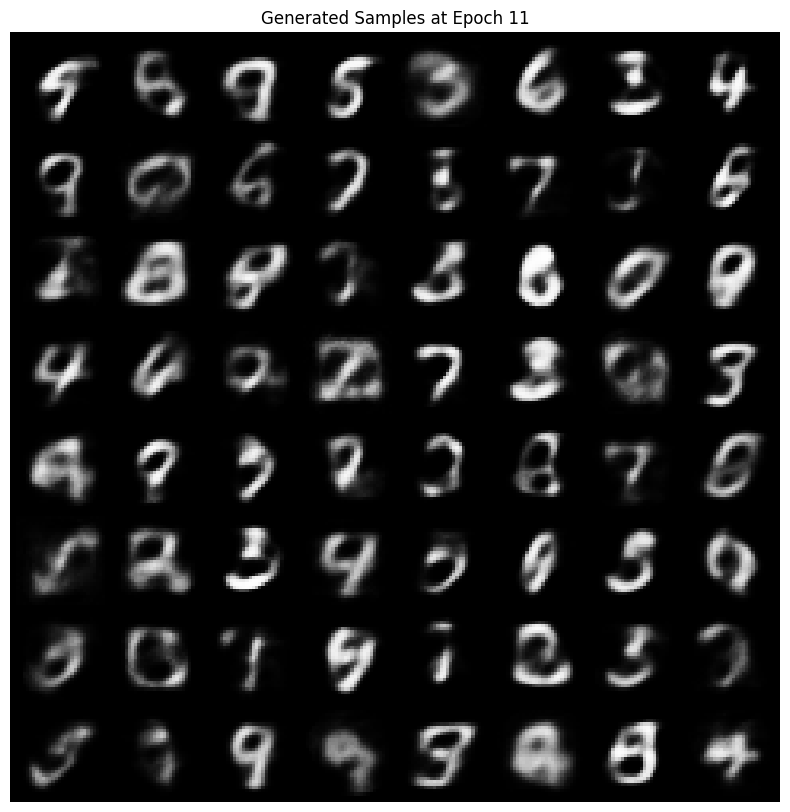

Epoch 12: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 123.1774


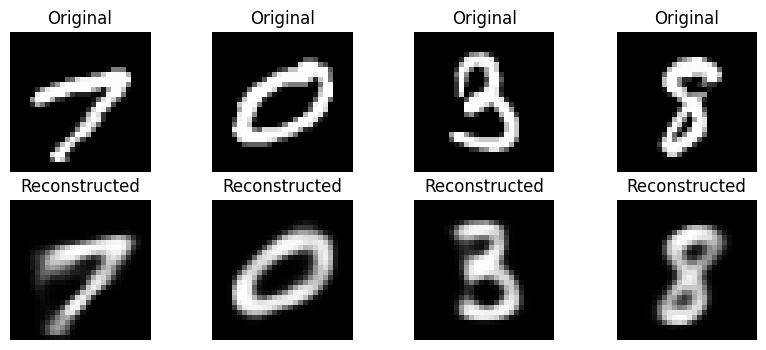

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 122.9953
Epoch 13: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 122.3492


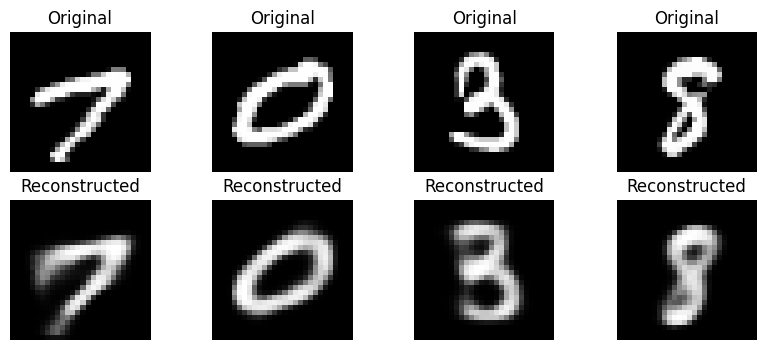

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 122.2533
Epoch 14: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 121.5825


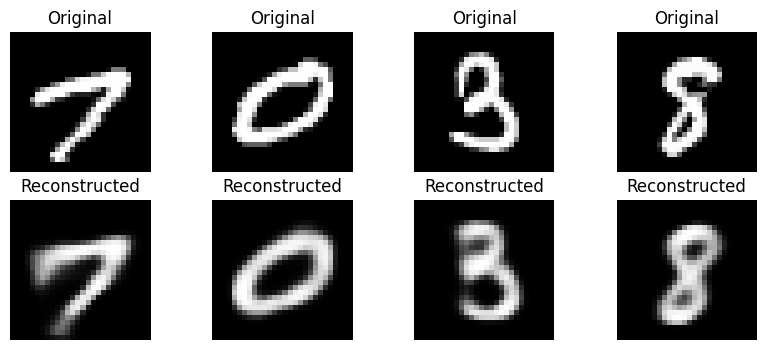

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 121.5076
Epoch 15: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 120.9224


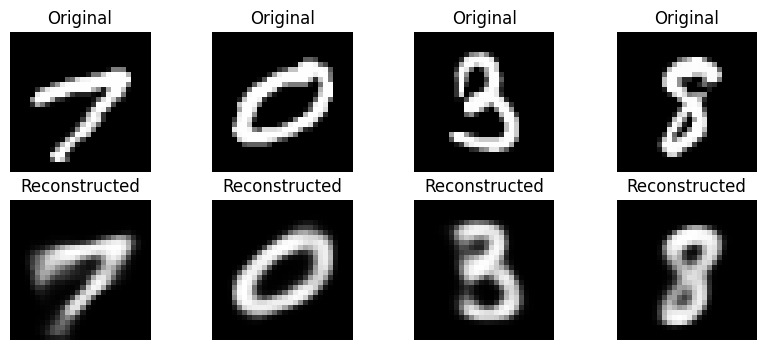

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 120.9770
Epoch 16: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 120.3711


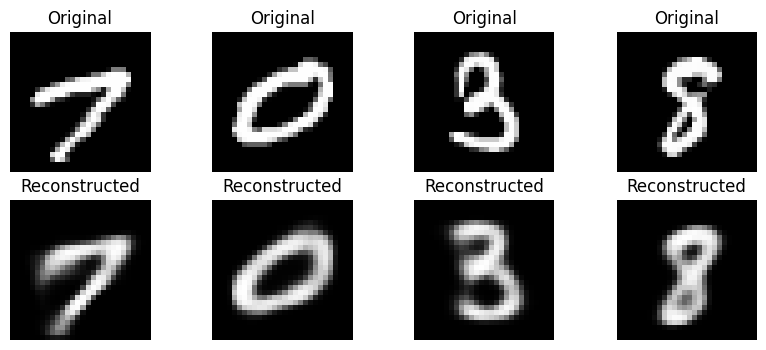

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 120.4294
Epoch 17: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 119.8701


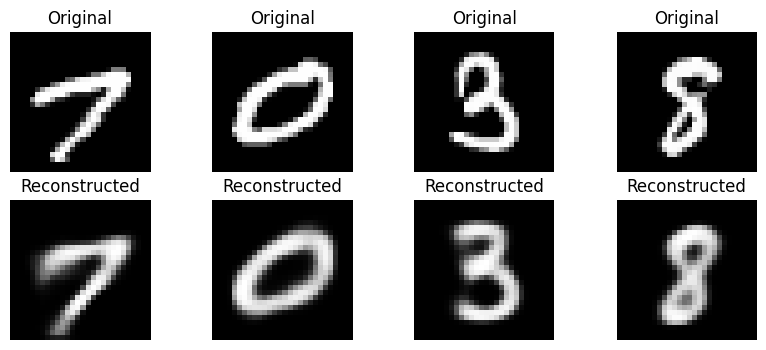

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.9455
Epoch 18: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 119.4058


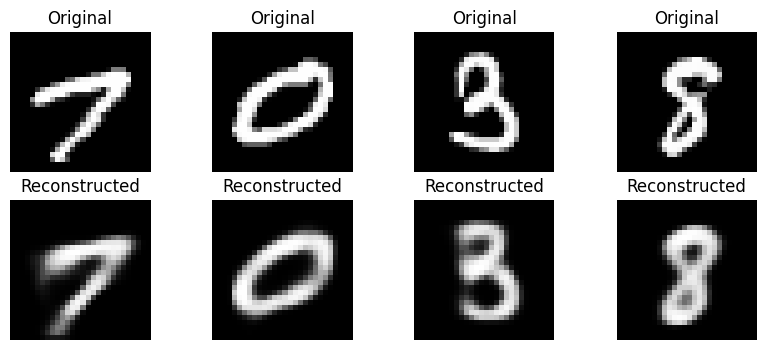

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.5683
Epoch 19: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 118.9455


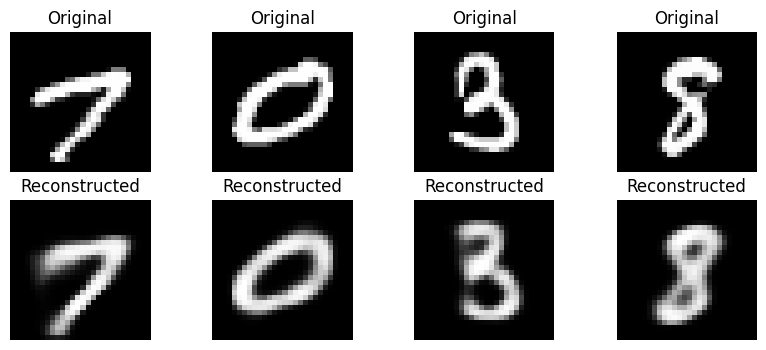

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 119.1331
Epoch 20: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 118.5652


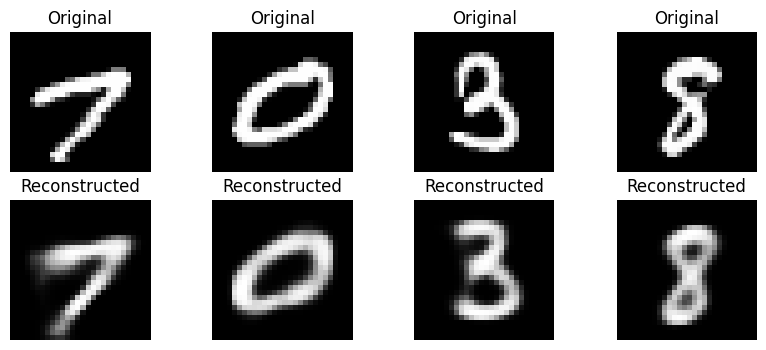

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.7304
Epoch 21: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 118.2184


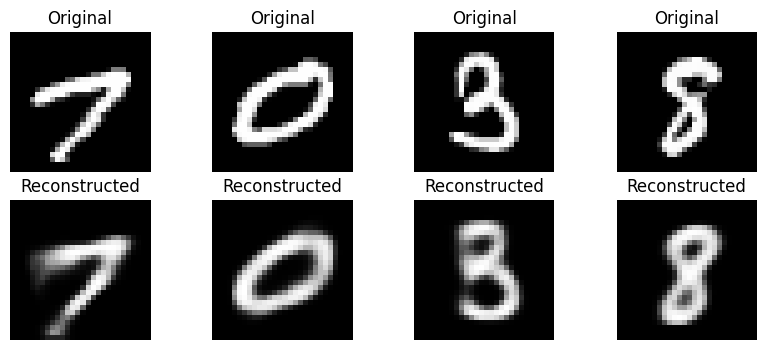

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.4048


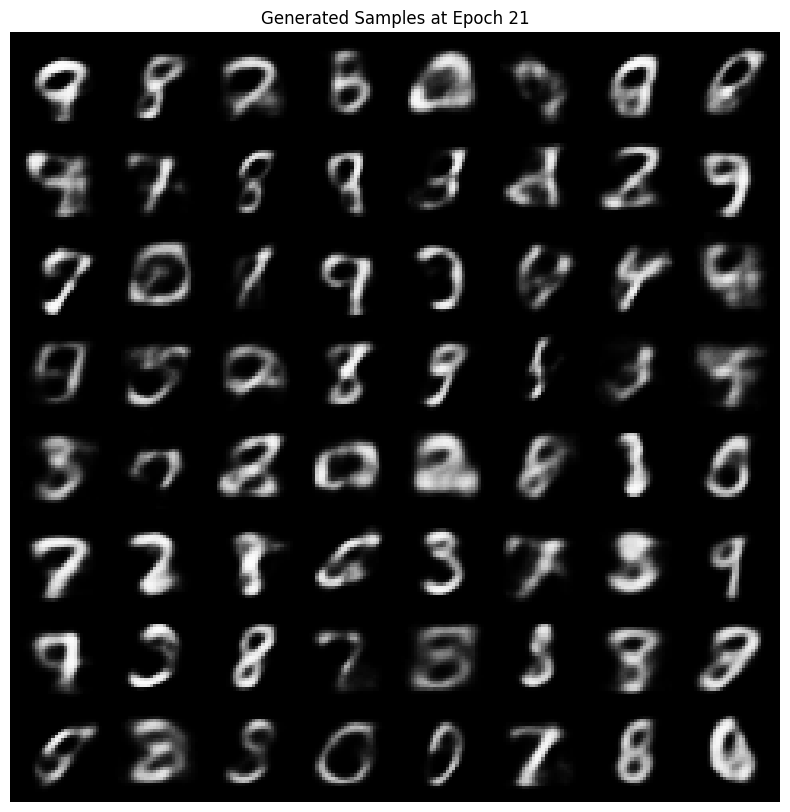

Epoch 22: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 117.8579


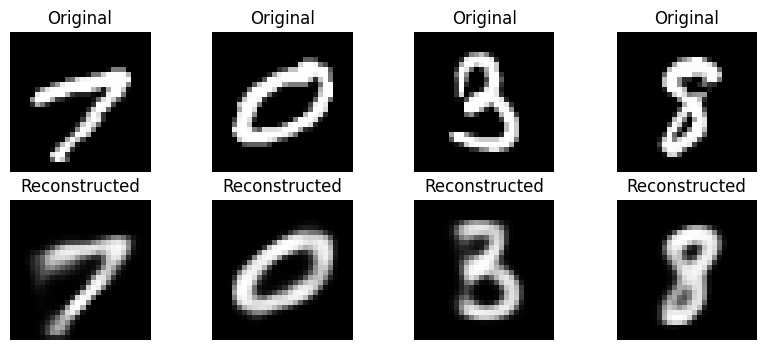

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 118.0647
Epoch 23: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 117.5883


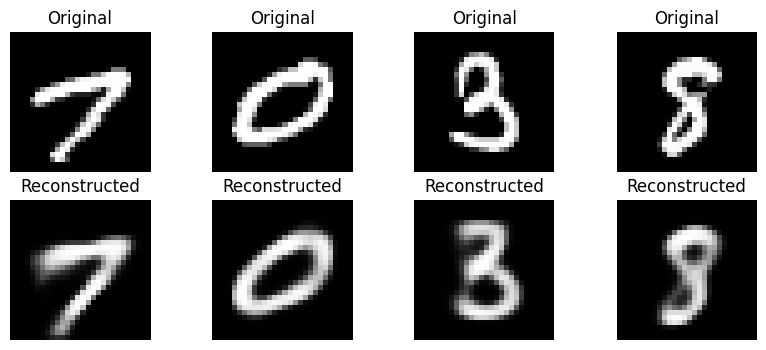

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.7893
Epoch 24: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 117.2575


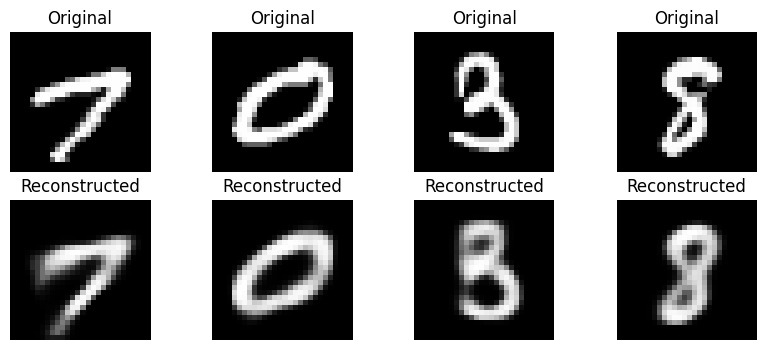

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.5561
Epoch 25: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 116.9999


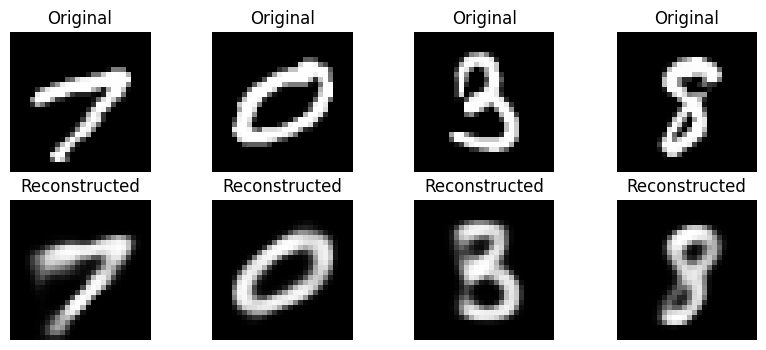

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.3119
Epoch 26: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 116.7664


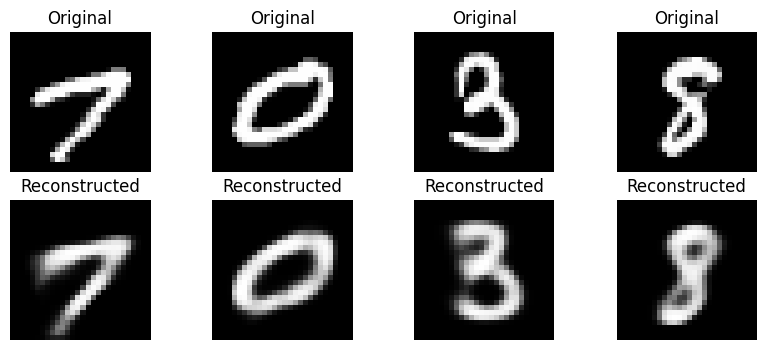

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 117.0550
Epoch 27: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 116.5185


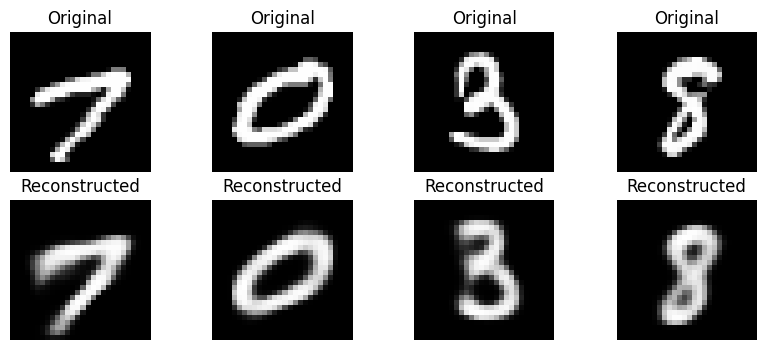

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.8153
Epoch 28: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 116.2476


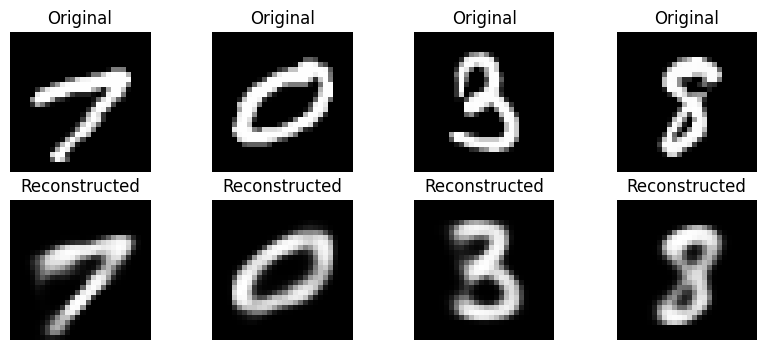

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.5890
Epoch 29: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 116.0472


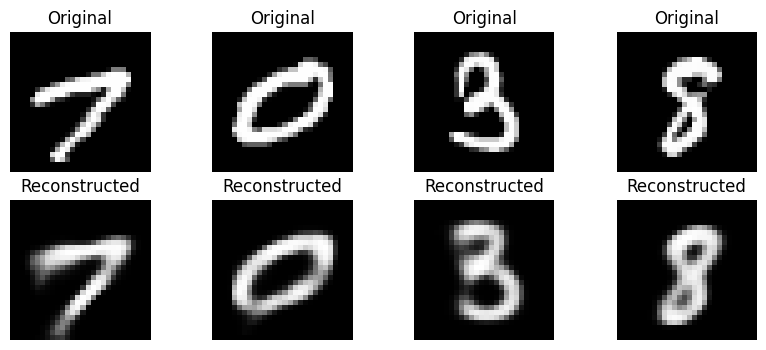

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.4233
Epoch 30: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 115.8449


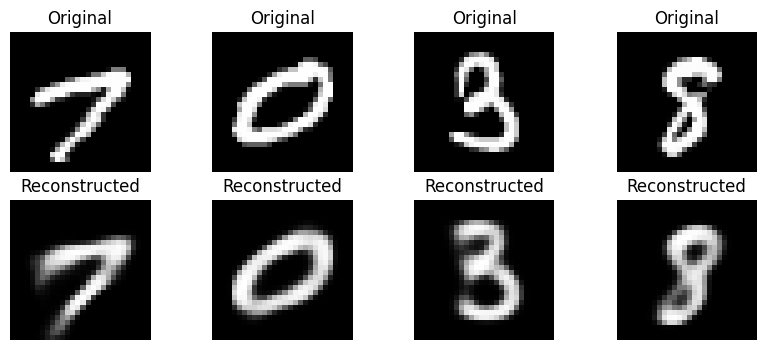

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 116.2259
Epoch 31: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 115.6426


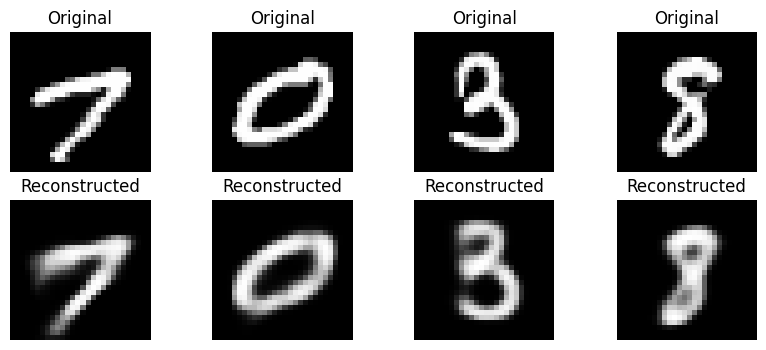

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.9466


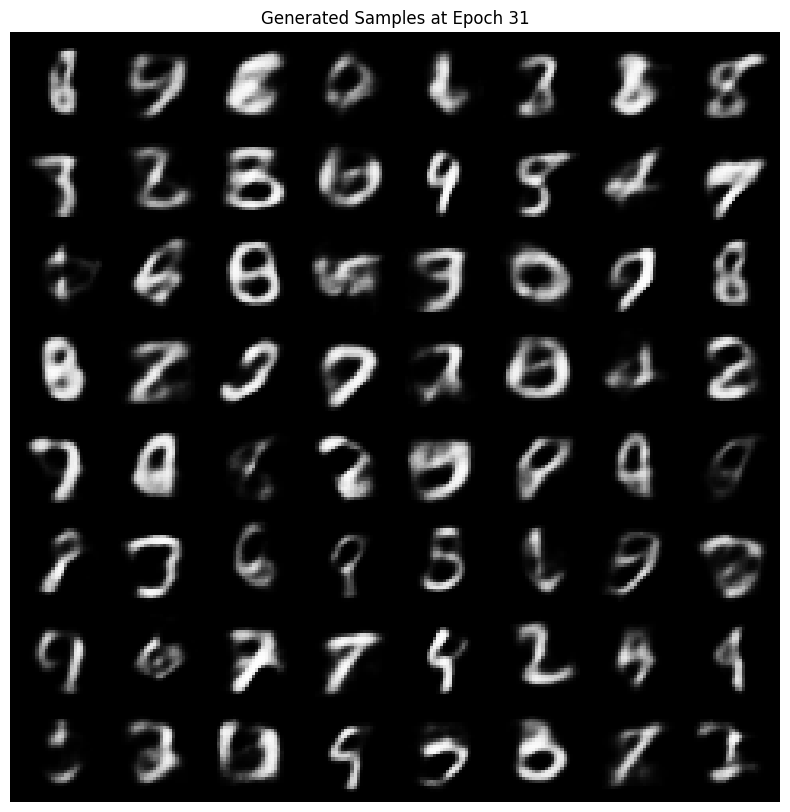

Epoch 32: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 115.4369


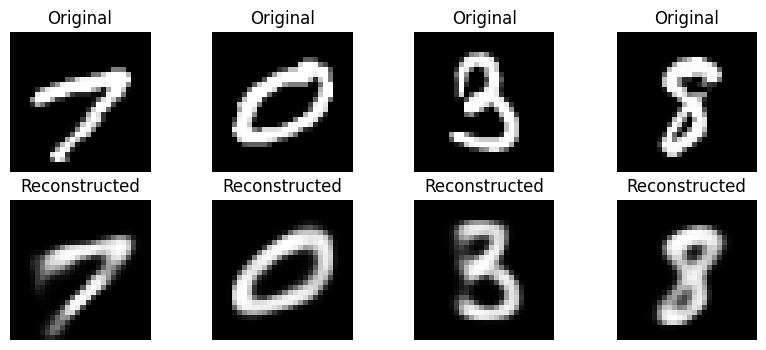

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.8135
Epoch 33: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 115.2735


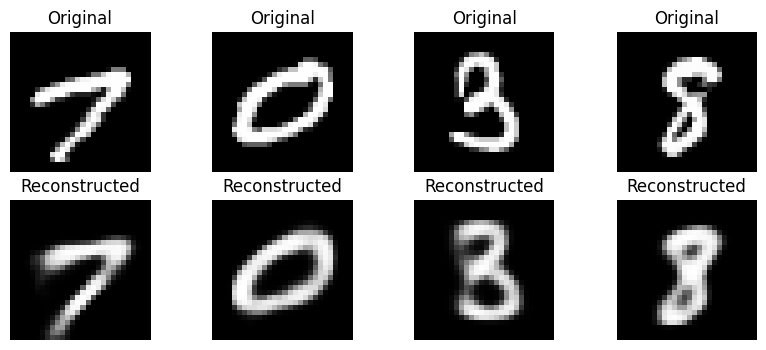

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.6445
Epoch 34: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 115.0849


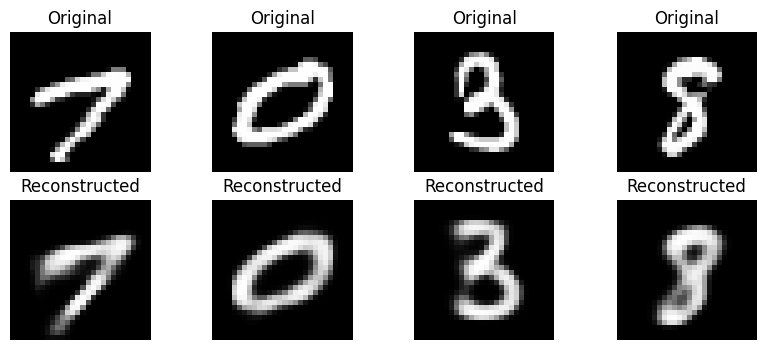

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.4898
Epoch 35: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.8987


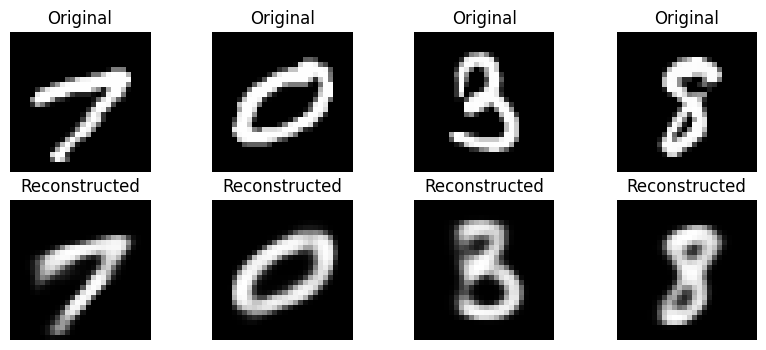

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.3909
Epoch 36: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.7617


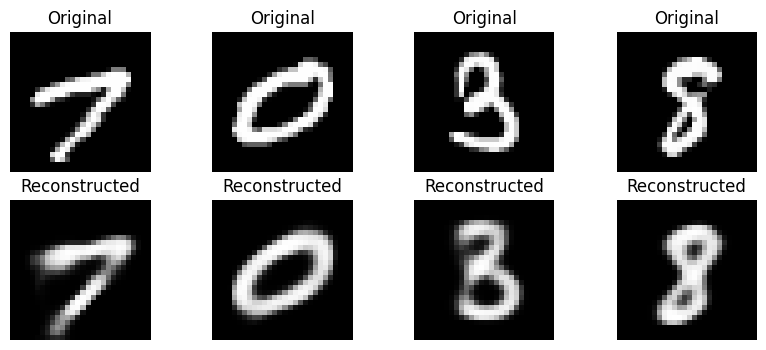

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.2812
Epoch 37: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.6161


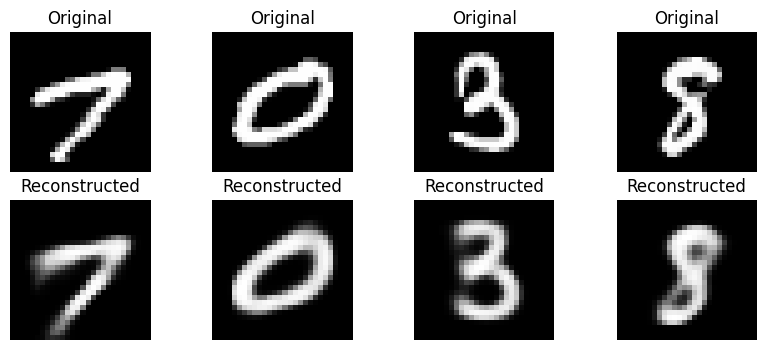

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 115.0666
Epoch 38: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.4481


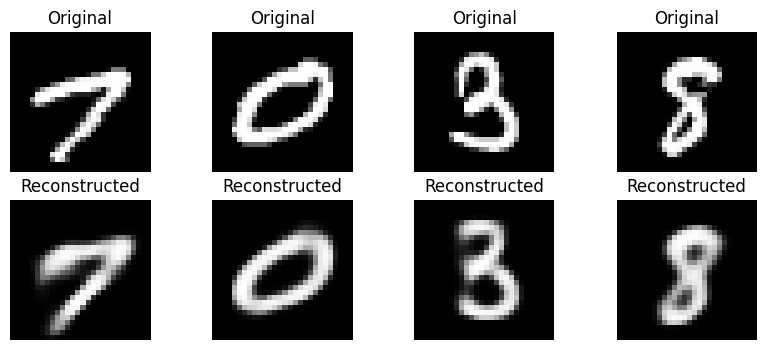

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.9518
Epoch 39: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.3069


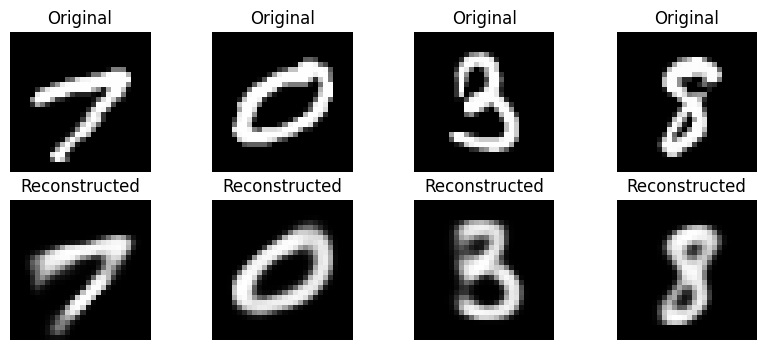

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.7744
Epoch 40: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.1798


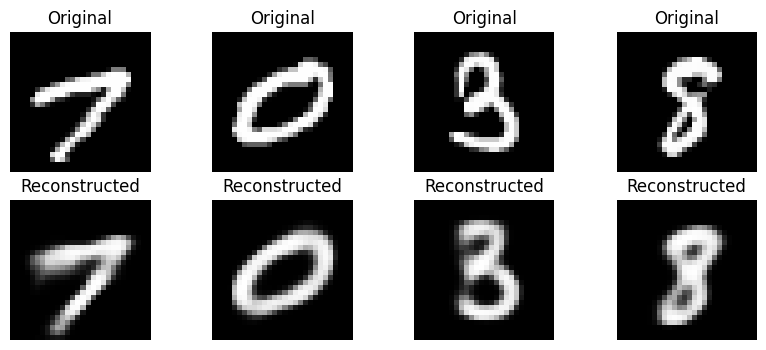

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.6086
Epoch 41: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 114.0510


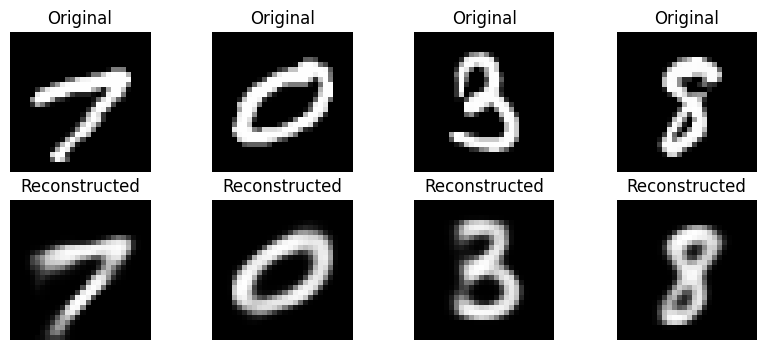

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.5706


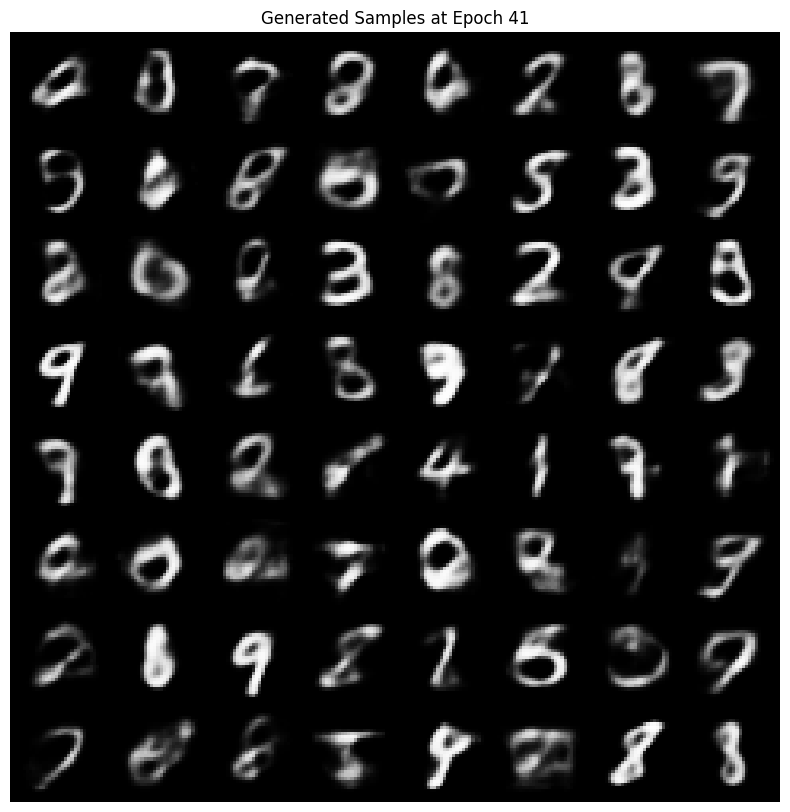

Epoch 42: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.8891


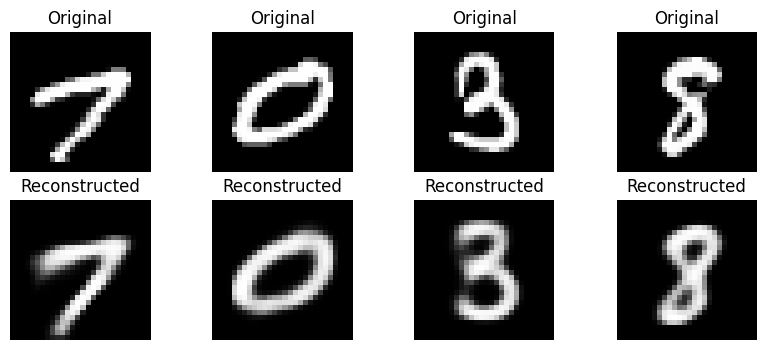

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.4102
Epoch 43: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.7851


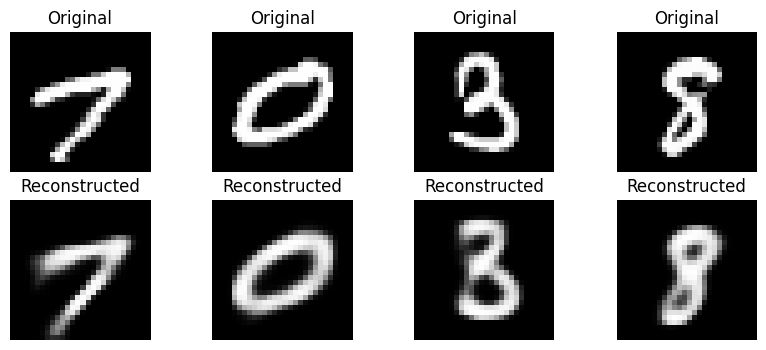

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.3925
Epoch 44: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.6482


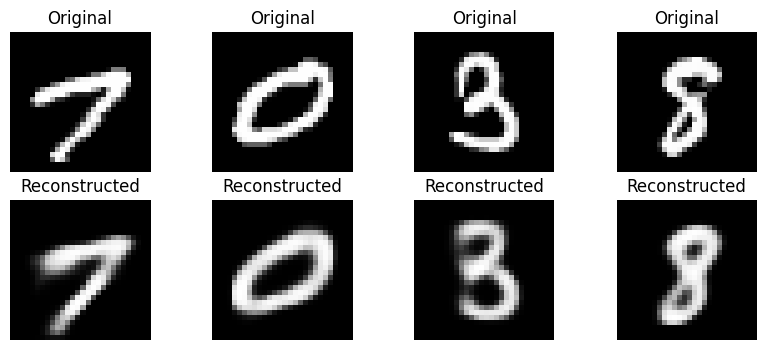

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.2284
Epoch 45: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.5478


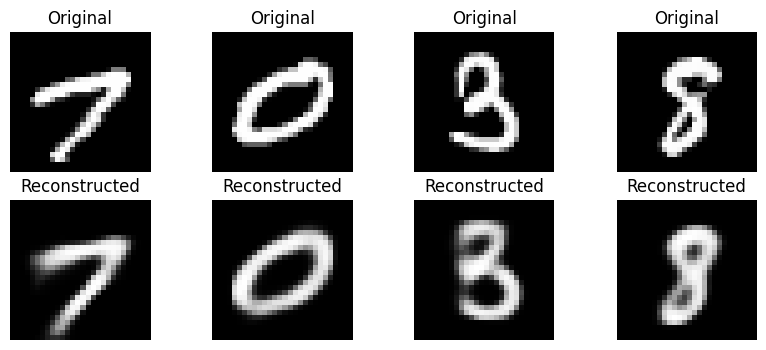

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 114.0558
Epoch 46: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.4170


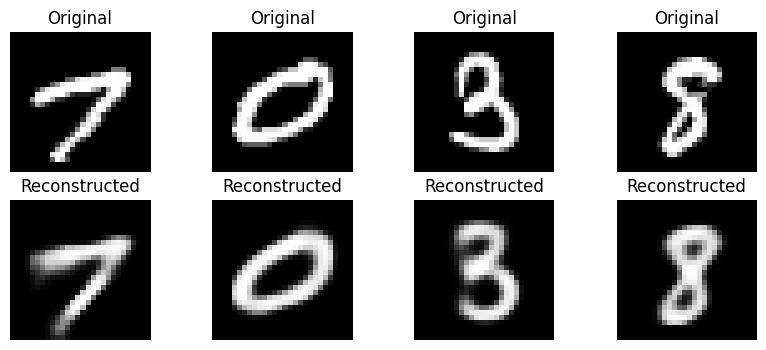

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.9267
Epoch 47: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.2888


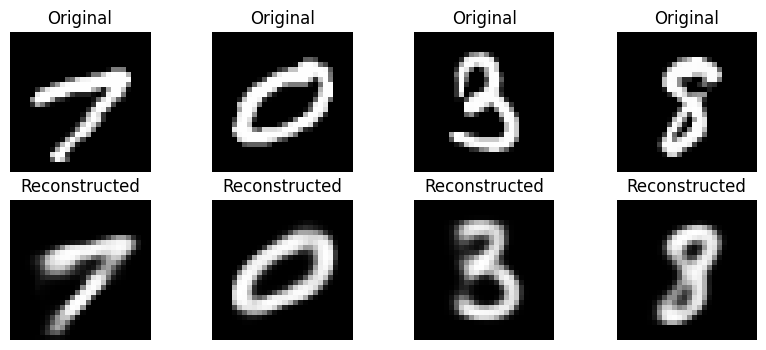

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.8450
Epoch 48: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.1901


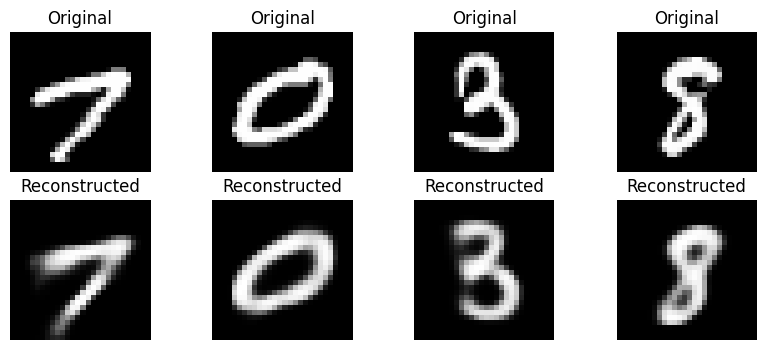

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.7807
Epoch 49: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.1259


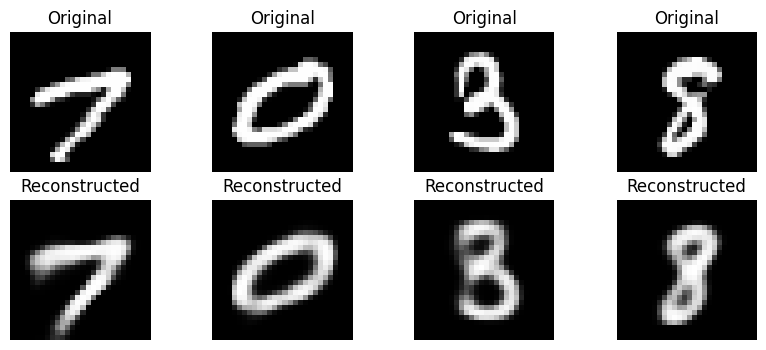

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.6373
Epoch 50: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 113.0147


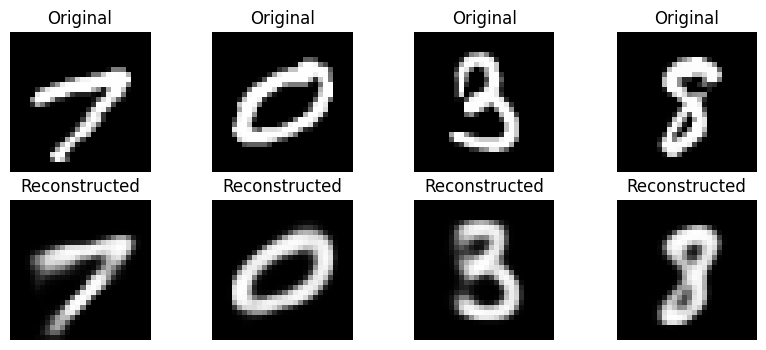

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.5840
Epoch 51: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.8794


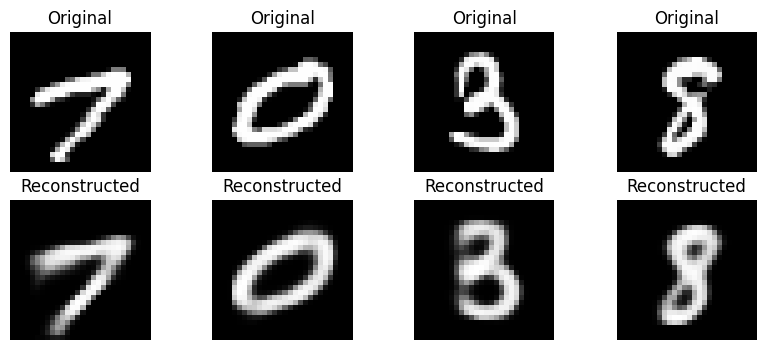

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.5286


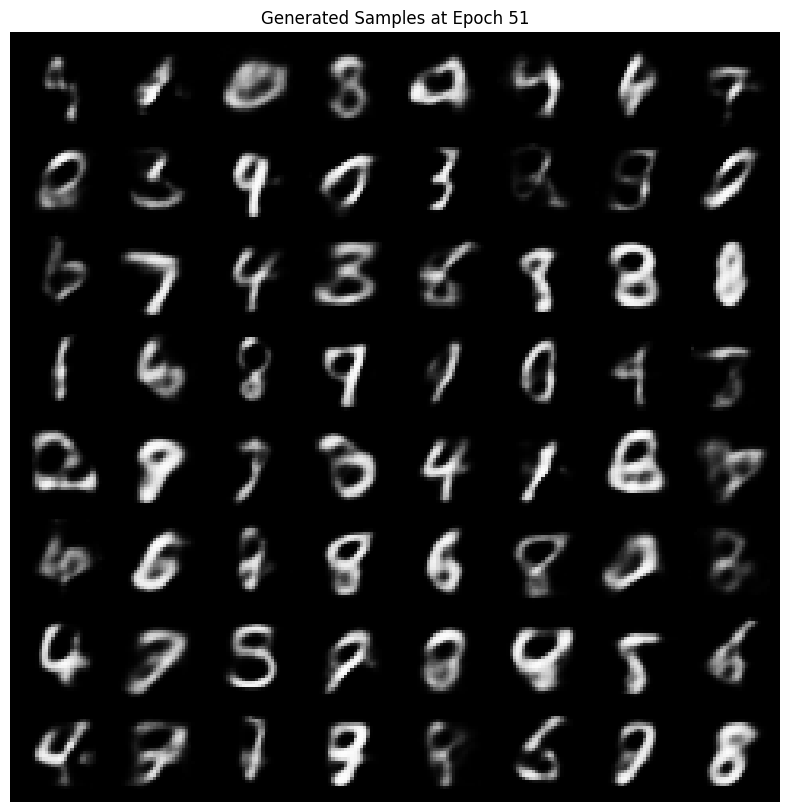

Epoch 52: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.7761


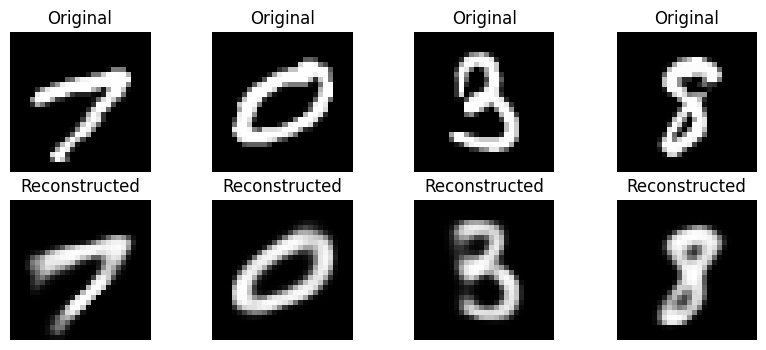

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.3896
Epoch 53: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.6905


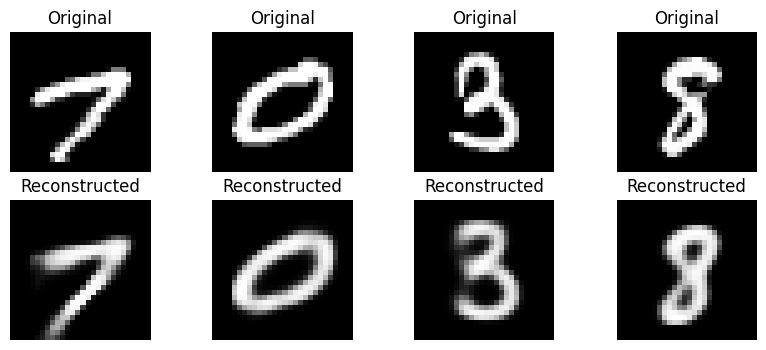

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.3376
Epoch 54: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.6050


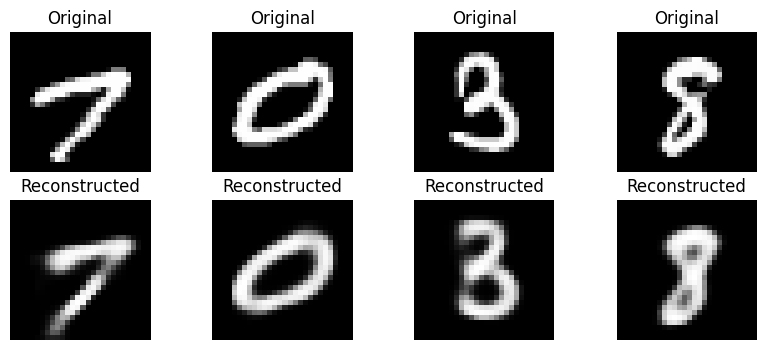

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.2560
Epoch 55: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.5187


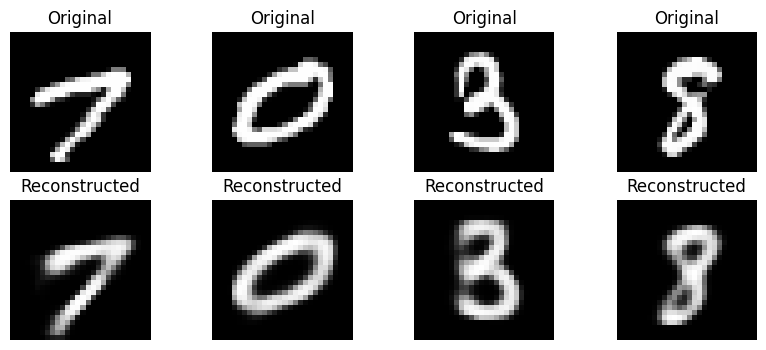

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.0755
Epoch 56: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.4316


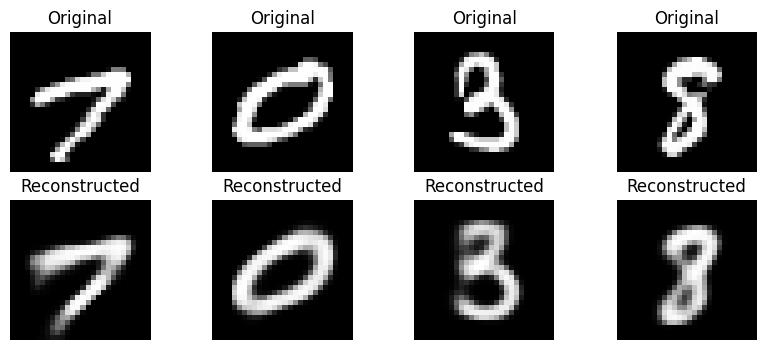

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.0604
Epoch 57: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.3496


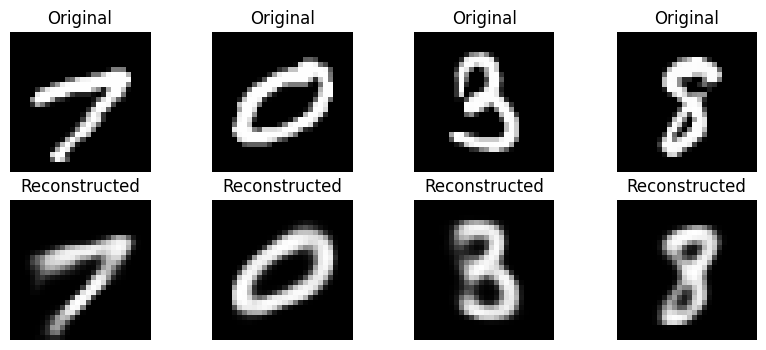

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 113.0053
Epoch 58: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.2608


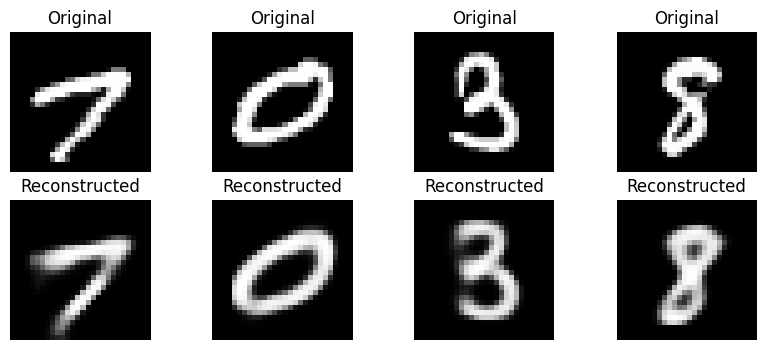

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.9427
Epoch 59: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.1918


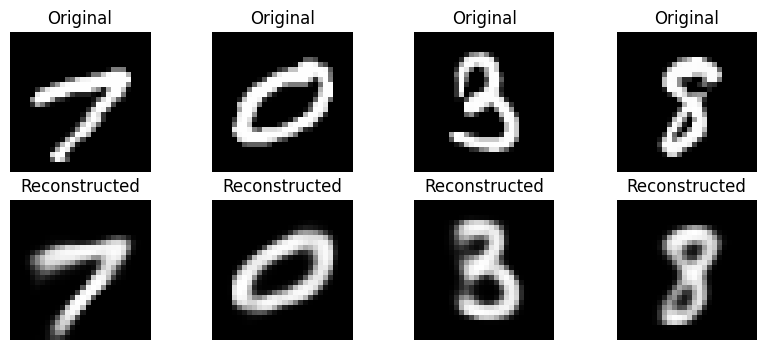

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.8257
Epoch 60: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.0913


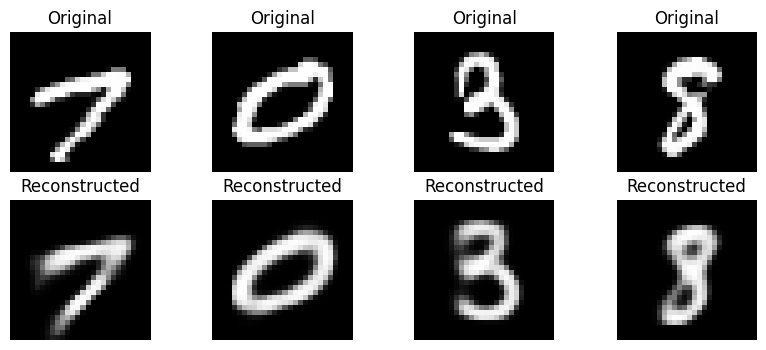

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.8550
Epoch 61: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 112.0294


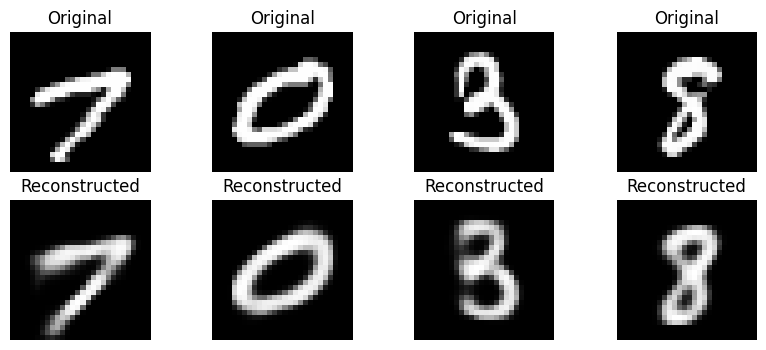

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.6897


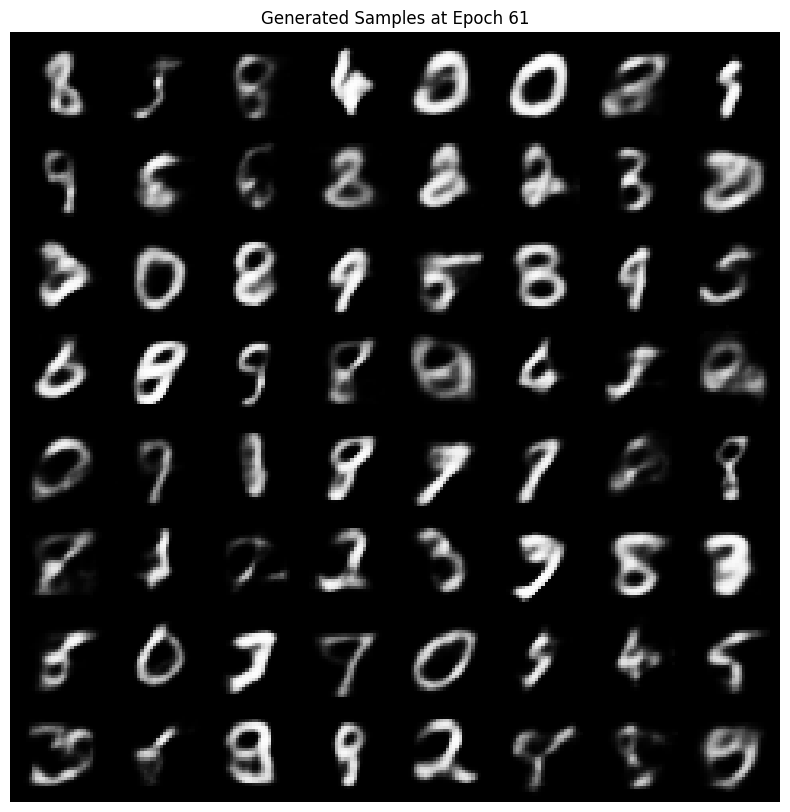

Epoch 62: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.9634


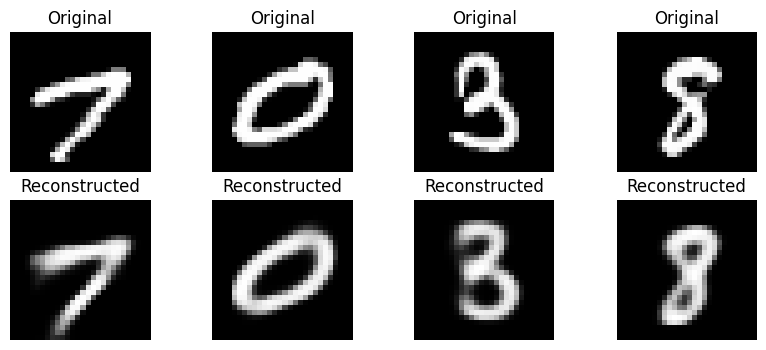

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.5649
Epoch 63: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.8540


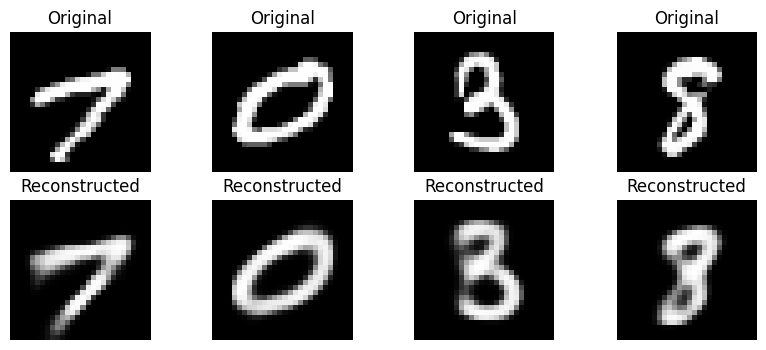

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4912
Epoch 64: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.7735


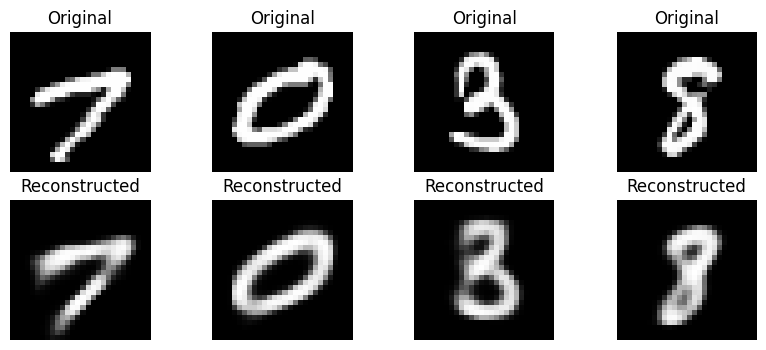

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4684
Epoch 65: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.7328


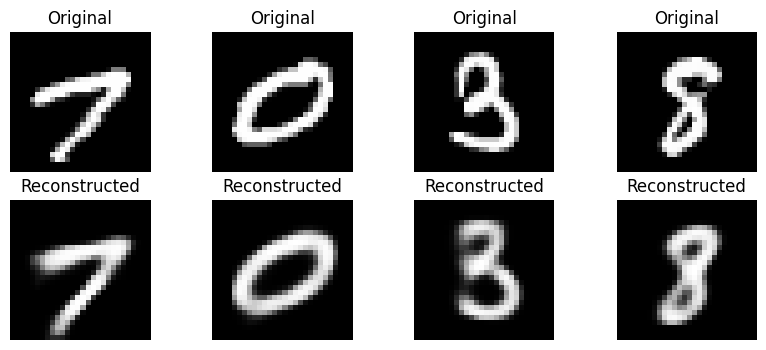

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.4055
Epoch 66: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.6444


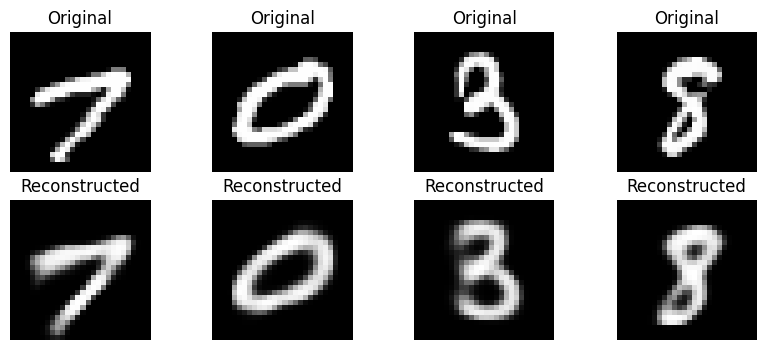

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.3010
Epoch 67: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.5743


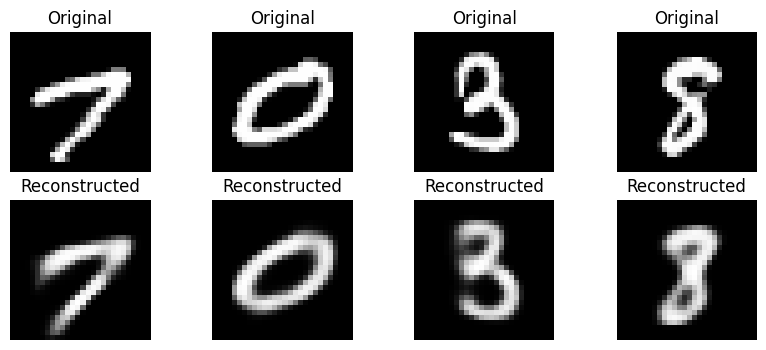

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.2418
Epoch 68: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.4891


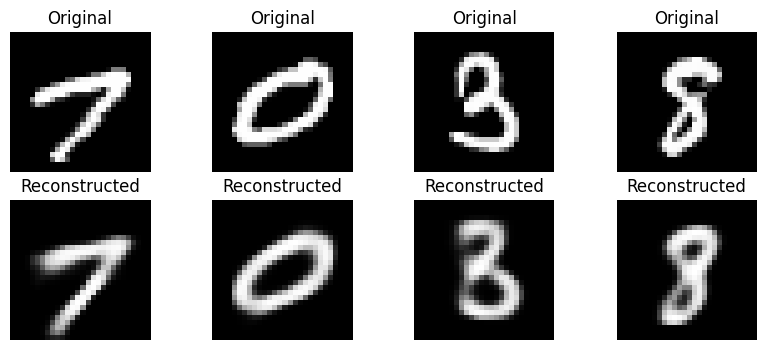

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.1455
Epoch 69: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.4277


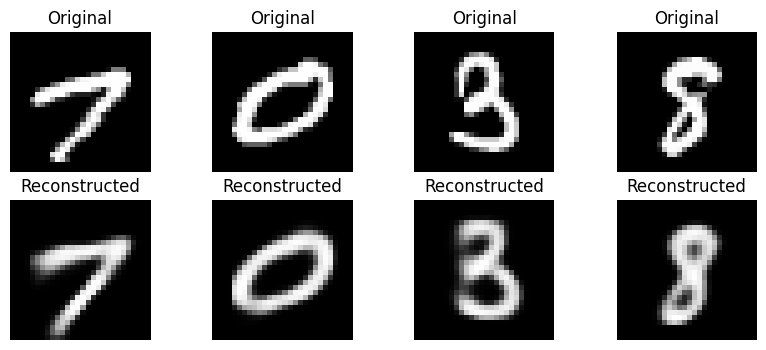

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.1844
Epoch 70: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.3692


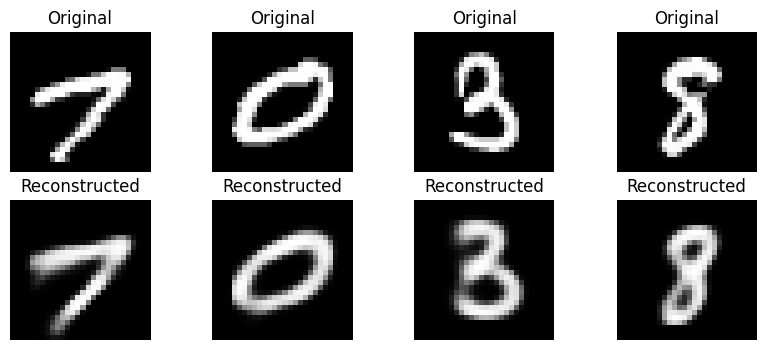

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.1570
Epoch 71: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.2864


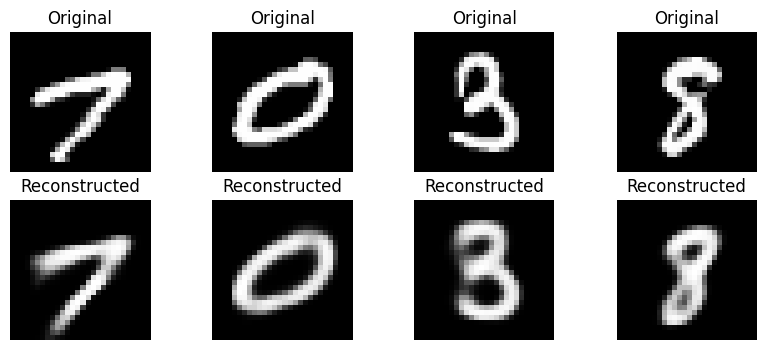

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.0582


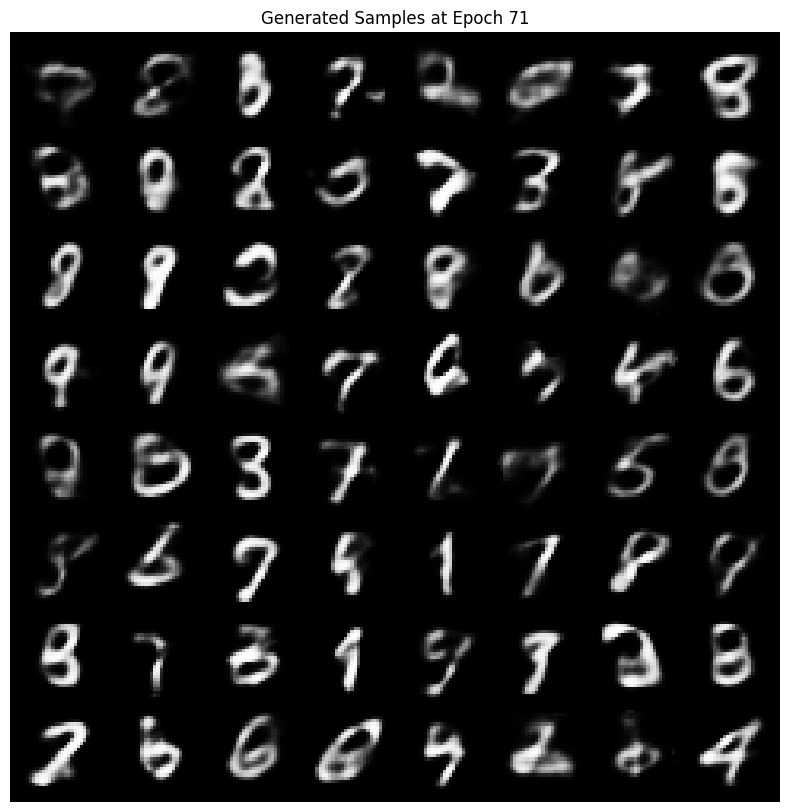

Epoch 72: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.2464


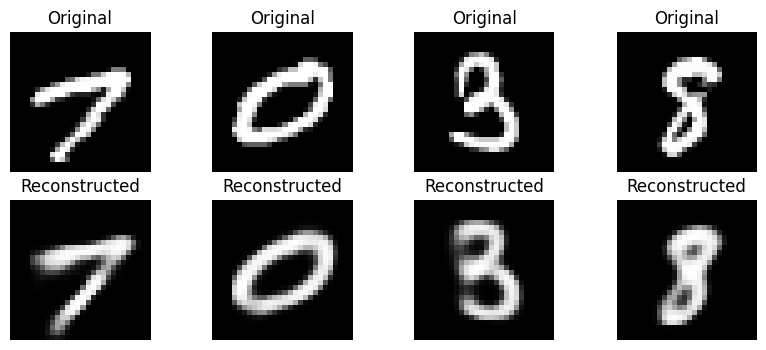

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 112.0385
Epoch 73: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.1816


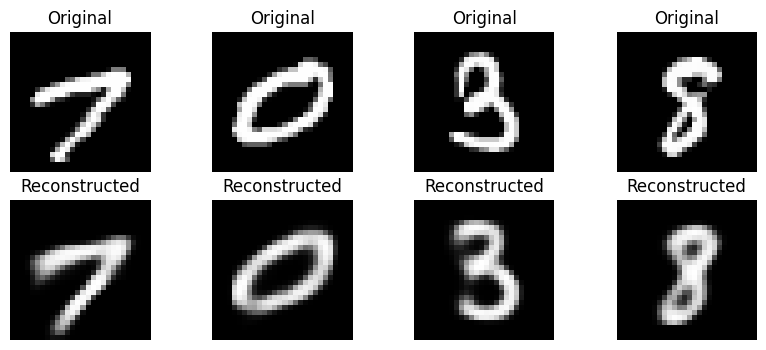

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.8522
Epoch 74: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.0751


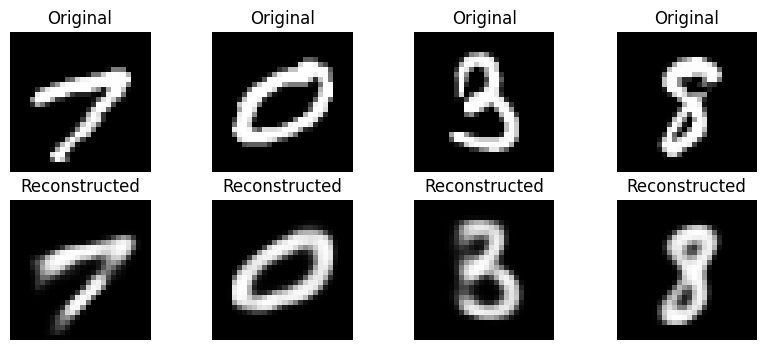

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.9102
Epoch 75: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.0289


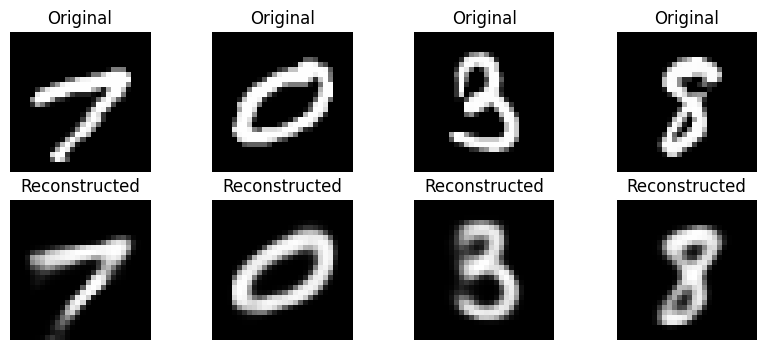

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7507
Epoch 76: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 111.0008


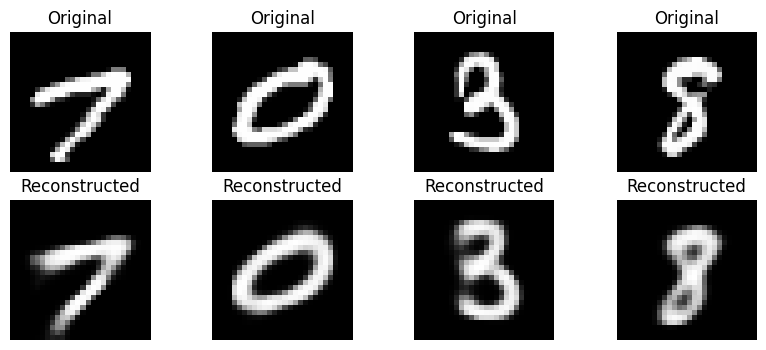

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.7513
Epoch 77: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.9327


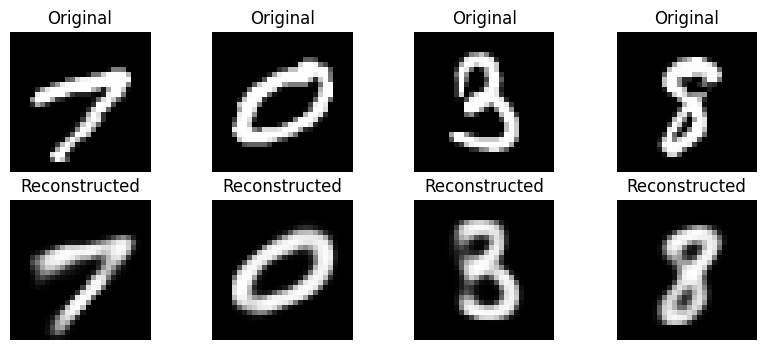

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.6910
Epoch 78: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.8602


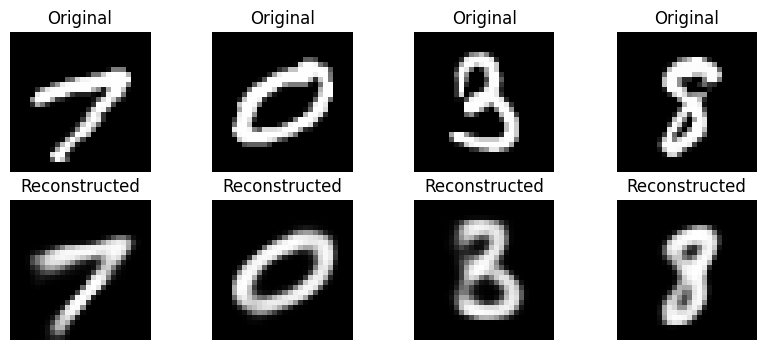

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.5935
Epoch 79: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.8243


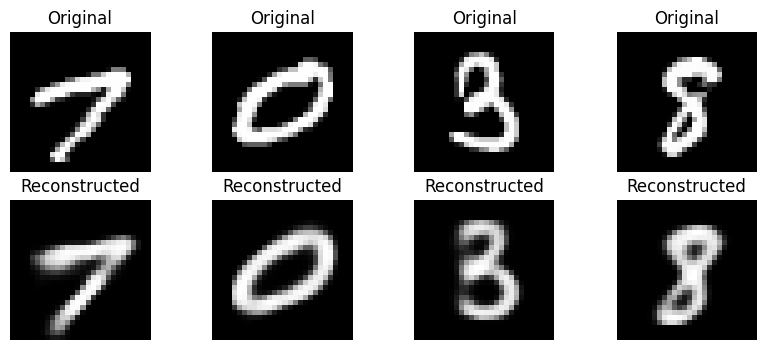

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.6158
Epoch 80: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.7298


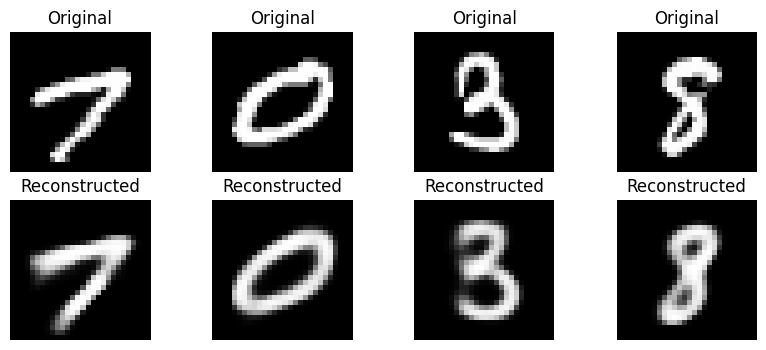

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.5381
Epoch 81: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.6759


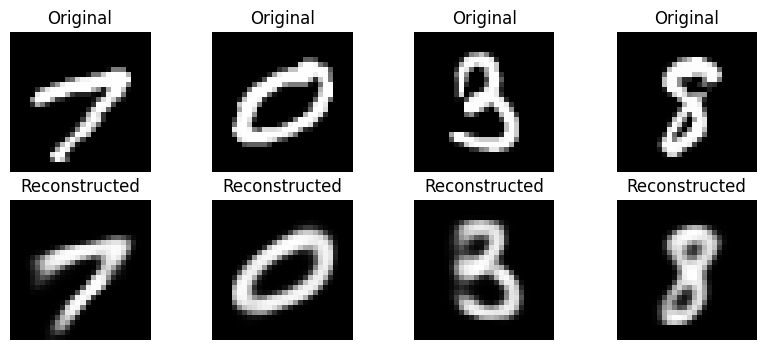

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.4583


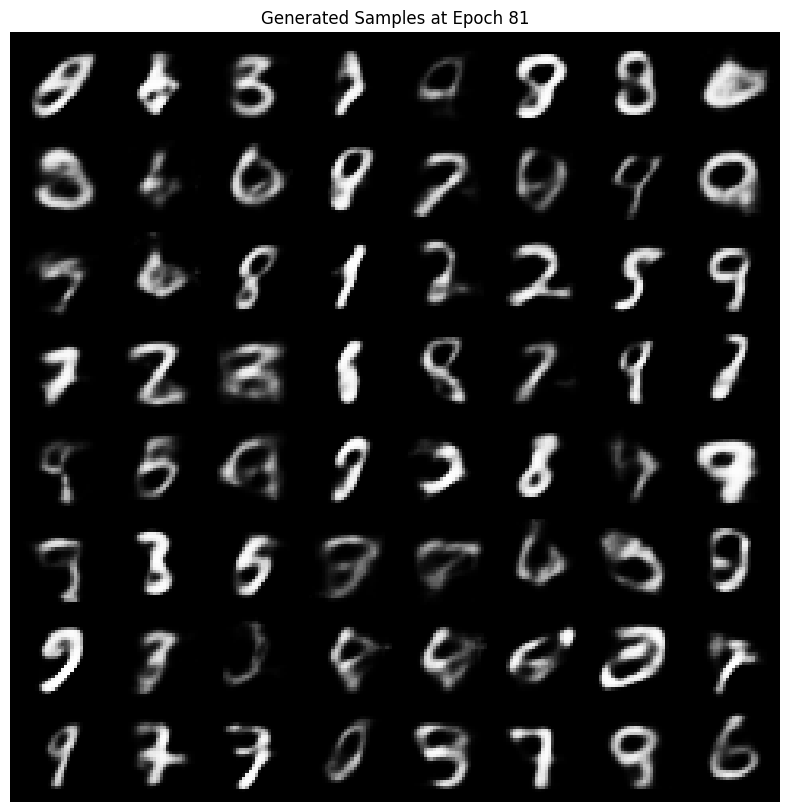

Epoch 82: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.6367


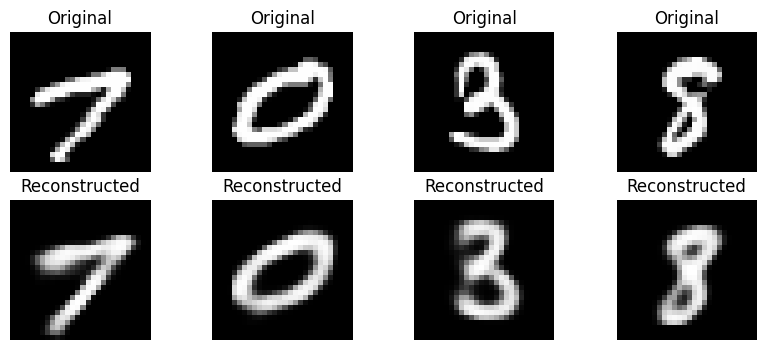

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.4647
Epoch 83: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.5687


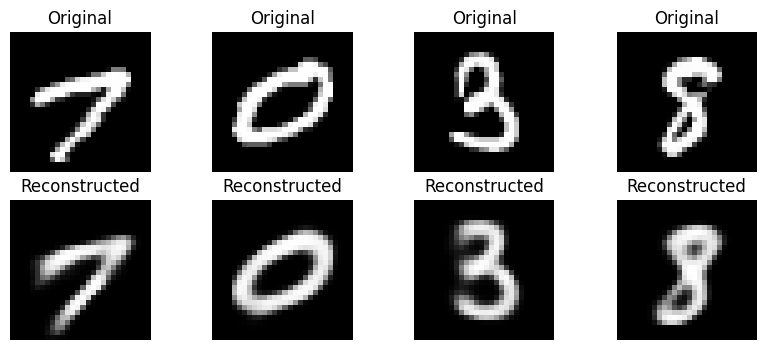

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.3479
Epoch 84: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.5504


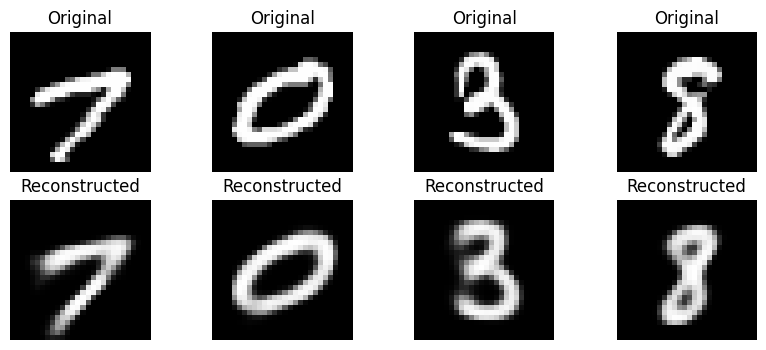

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.3295
Epoch 85: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.4853


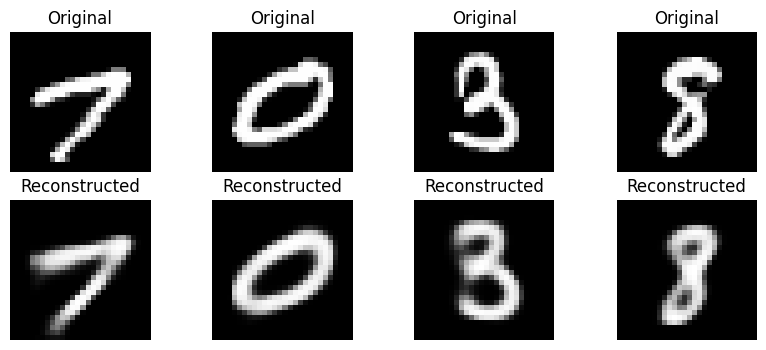

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.4216
Epoch 86: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.4256


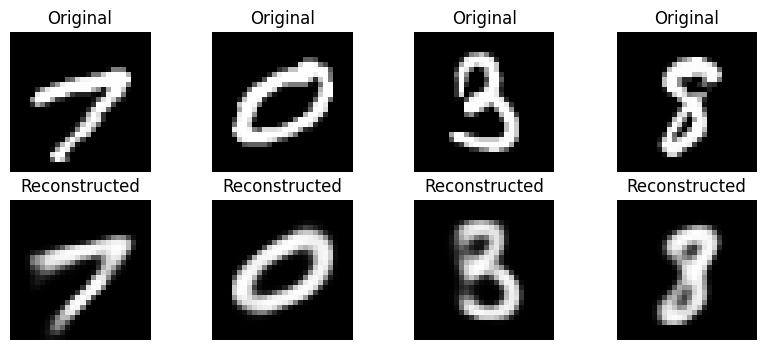

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.2010
Epoch 87: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.3914


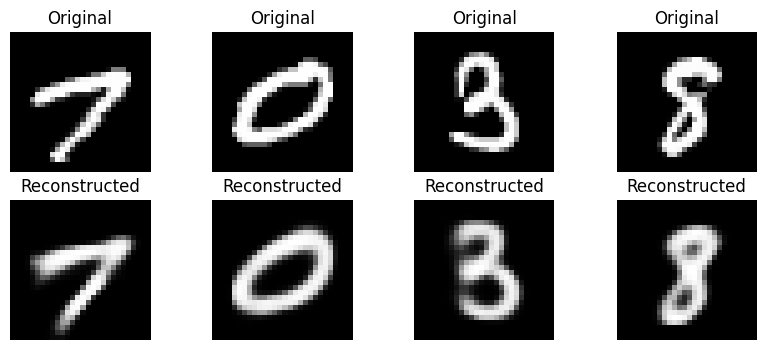

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.2430
Epoch 88: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.3399


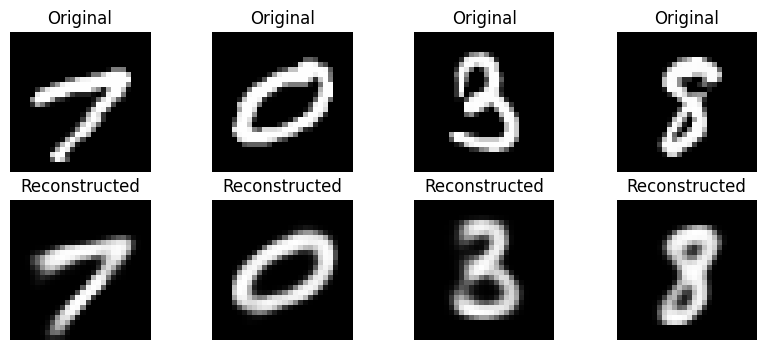

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.1709
Epoch 89: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.2570


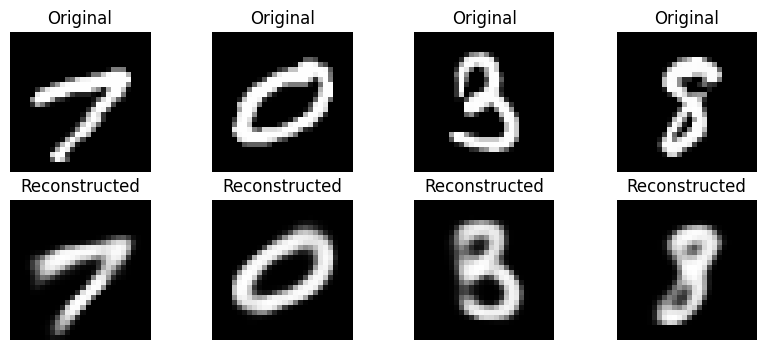

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.1723
Epoch 90: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.2095


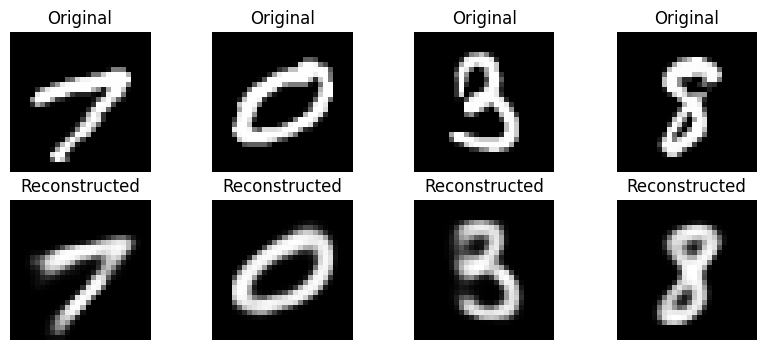

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.1280
Epoch 91: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.1921


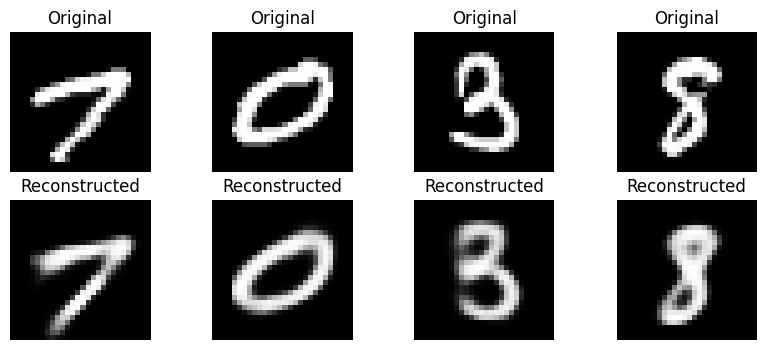

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.0054


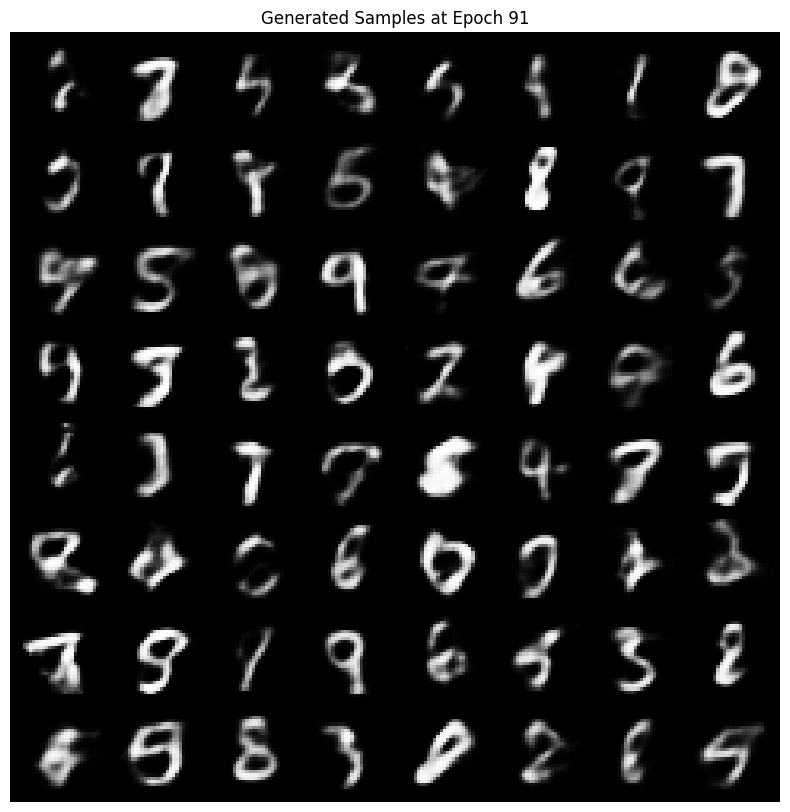

Epoch 92: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.1239


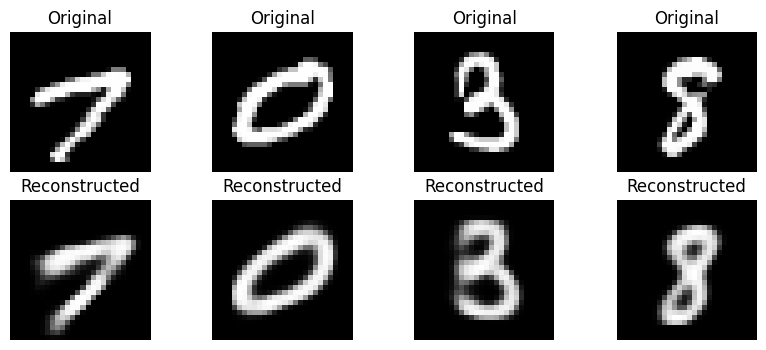

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.0362
Epoch 93: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.0768


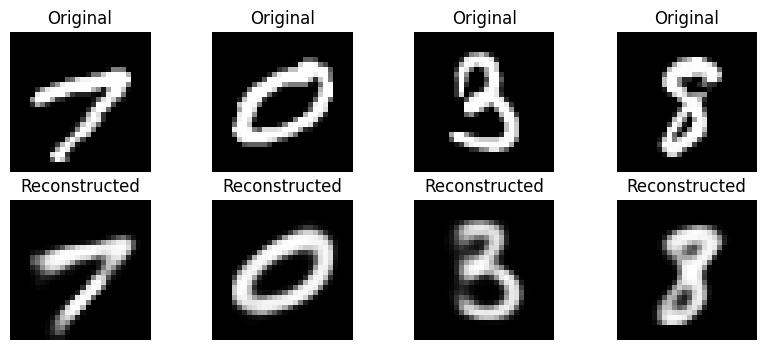

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.9563
Epoch 94: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 110.0412


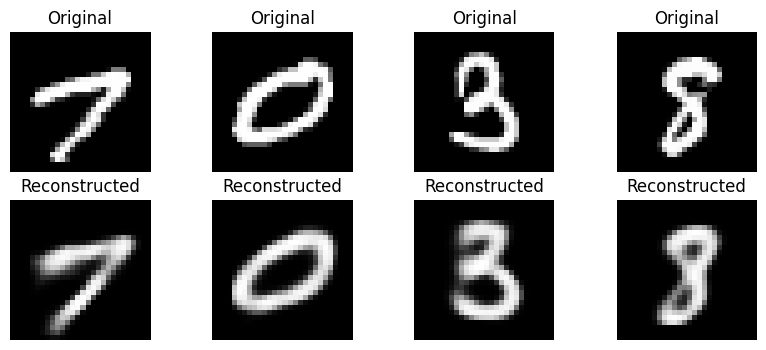

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 111.0283
Epoch 95: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.9680


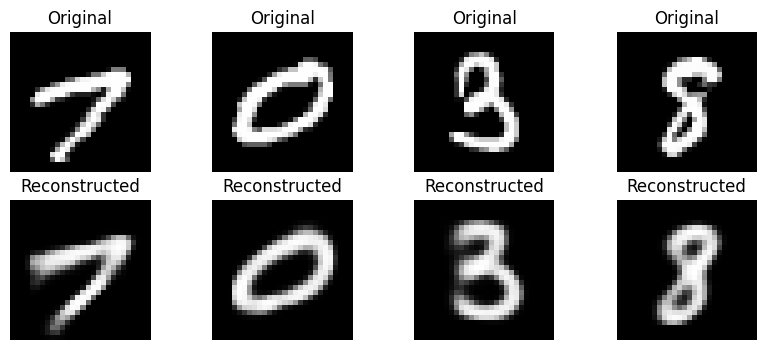

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.8710
Epoch 96: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.9213


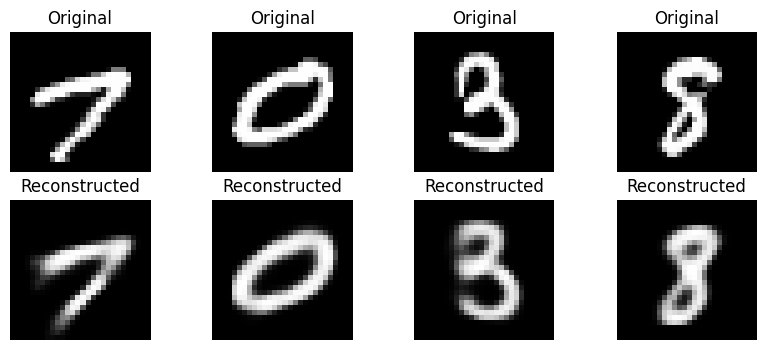

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.8671
Epoch 97: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.8884


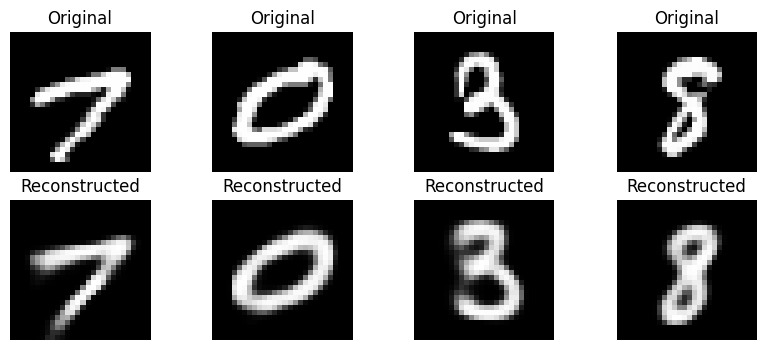

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.8206
Epoch 98: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.8631


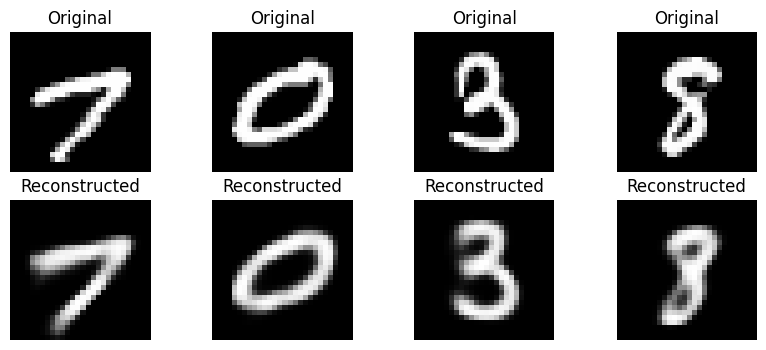

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.7247
Epoch 99: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.8298


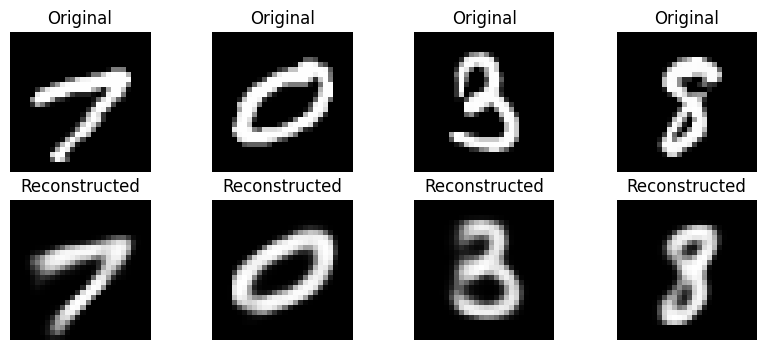

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.7513
Epoch 100: 


  0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 109.7621


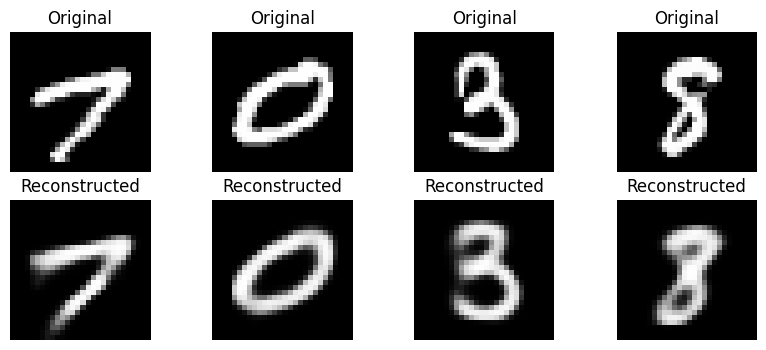

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 110.6372


In [ ]:
input_dim = 784
hidden_dim = 256
latent_dim = 10
model, vae_val_loss = train_vae(train_loader, val_loader, latent_dim, hidden_dim, input_dim, num_epochs=100)

In [ ]:
torch.save(model.state_dict(), data_path+'vae_model.pth')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        # linear -> BN -> Act Func -> linear -> BN -> Act Func -> Unflatten -> Convrans2D -> BN2D -> Act func -> Convrans2D -> BN2D -> Act func -> Conv -> Act Func
        #######################

        self.img_shape = img_shape

        self.model = nn.Sequential(
            # Start with a linear block to project the latent vector
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Project to a size suitable for reshaping into a feature map
            nn.Linear(256, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),

            # Unflatten to a 4D tensor (batch, channels, height, width)
            nn.Unflatten(1, (128, 7, 7)),

            # Upsample to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 28x28
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Final convolution to get 1 channel image
            nn.Conv2d(32, self.img_shape[0], kernel_size=3, stride=1, padding=1),
            # Use Tanh to ensure output is in [-1, 1], which is common for GANs
            nn.Tanh()
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        img = self.model(z)

        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        # Conv -> Act Func -> Conv -> BN2D -> Act -> Conv -> BN2D -> Act -> Flatten -> linear -> Act
        ###########################

        channels, height, width = img_dim
        self.model = nn.Sequential(
            # Input: (batch, 1, 28, 28)
            nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1), # -> (batch, 32, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (batch, 64, 7, 7)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> (batch, 128, 4, 4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            # Output a single value (logit) indicating realness
            nn.Linear(128 * 4 * 4, 1)
            # No sigmoid here, as we will use BCEWithLogitsLoss for stability
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        validity = self.model(img)
        return validity

In [12]:
def train_gan(dataloader, val_loader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE)
    discriminator = Discriminator(img_shape).to(DEVICE)
    # Use BCEWithLogitsLoss for numerical stability (combines Sigmoid + BCELoss)
    adversarial_loss = nn.BCEWithLogitsLoss()
    # Adam optimizer is a common choice for GANs
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    val_gen_losses, val_dis_losses = [], []
    for epoch in range(num_epochs):
        # Set models to training mode
        generator.train()
        discriminator.train()
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:


                # Move real images to device
                real_imgs = imgs.to(DEVICE)

                # Create labels for real (1) and fake (0) images
                valid = torch.ones(imgs.size(0), 1, device=DEVICE)
                fake = torch.zeros(imgs.size(0), 1, device=DEVICE)

                # Train Generator# Sample noise as generator input
                optimizer_G.zero_grad()
                # Sample noise as generator input
                z = torch.randn(imgs.size(0), latent_dim, device=DEVICE)
                # Generate a batch of images
                generated_imgs = generator(z)
                # Generator loss: measures how well it fools the discriminator
                # We use 'valid' labels because the generator's goal is to make the discriminator think its images are real
                g_loss = adversarial_loss(discriminator(generated_imgs), valid)
                # Backpropagate and update generator weights
                g_loss.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                # Discriminator loss for real images
                real_loss = adversarial_loss(discriminator(real_imgs), valid)

                # Discriminator loss for fake images
                # .detach() is crucial: we don't want to backpropagate into the generator while training the discriminator
                fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)

                # Total discriminator loss is the average of real and fake loss
                d_loss = (real_loss + fake_loss) / 2

                # Backpropagate and update discriminator weights
                d_loss.backward()
                optimizer_D.step()

                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch
        # Set models to evaluation mode for validation and plotting
        generator.eval()
        discriminator.eval()
        val_loss = [0., 0.]
        with torch.no_grad():
          with tqdm(enumerate(val_loader), total=len(val_loader)) as vbar:
              for i, (imgs, _) in vbar:
                  real_imgs = imgs.to(DEVICE)
                  # valid and fake labels
                  valid = torch.ones(imgs.size(0), 1, device=DEVICE)
                  fake = torch.zeros(imgs.size(0), 1, device=DEVICE)

                  # Train Generator# Sample noise as generator input
                  # Sample noise for generator
                  z = torch.randn(imgs.size(0), latent_dim, device=DEVICE)
                  # Calculate Generator loss
                  generated_imgs = generator(z)
                  g_loss = adversarial_loss(discriminator(generated_imgs), valid)

                  # Calculate Discriminator loss
                  real_loss = adversarial_loss(discriminator(real_imgs), valid)
                  fake_loss = adversarial_loss(discriminator(generated_imgs), fake)
                  d_loss = (real_loss + fake_loss) / 2


                  # TODO
                  # Calculate and fill discriminator and generator losses
                  vbar.set_description("[Validation] [D loss: {:.4f}] [G loss: {:.4f}]".format(d_loss.item(), g_loss.item()))
                  val_loss[0] = val_loss[0] + g_loss.item()
                  val_loss[1] = val_loss[1] + d_loss.item()

              val_gen_losses.append(val_loss[0] / len(val_loader))
              val_dis_losses.append(val_loss[1] / len(val_loader))
              print("[Validation avg loss] ----- [D loss: {:.4f}] [G loss: {:.4f}]".format(val_dis_losses[-1], val_gen_losses[-1]))

        z = torch.randn(8, latent_dim, device=DEVICE)
        generated_imgs = generator(z)
        grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.show()


    return generator, discriminator, val_gen_losses, val_dis_losses

In [17]:
latent_dim = 100

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5480] [G loss: 0.5653]


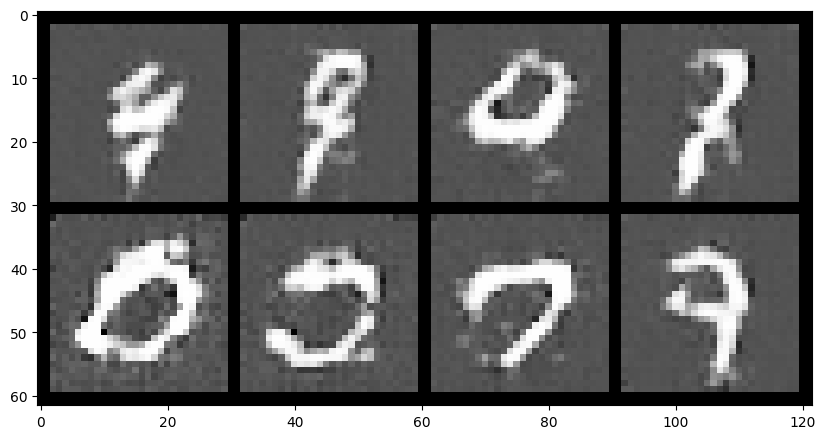

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.4402] [G loss: 1.2951]


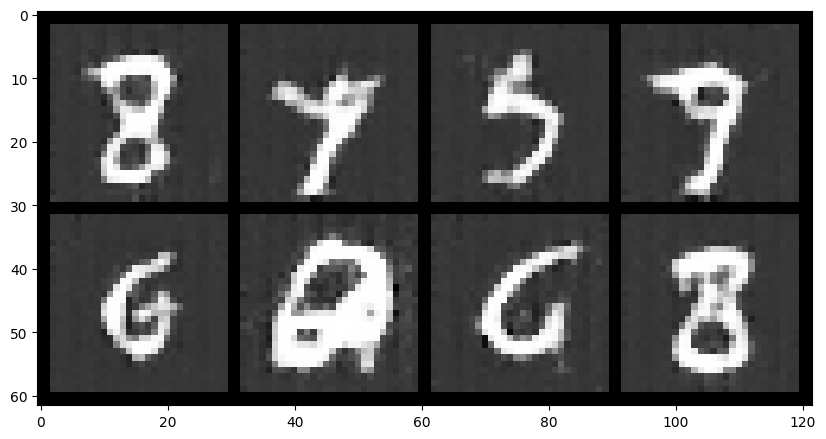

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5623] [G loss: 0.6242]


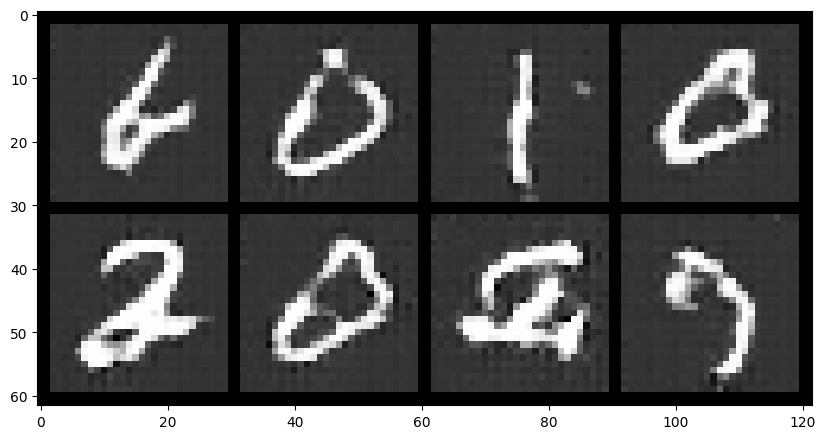

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5557] [G loss: 1.1669]


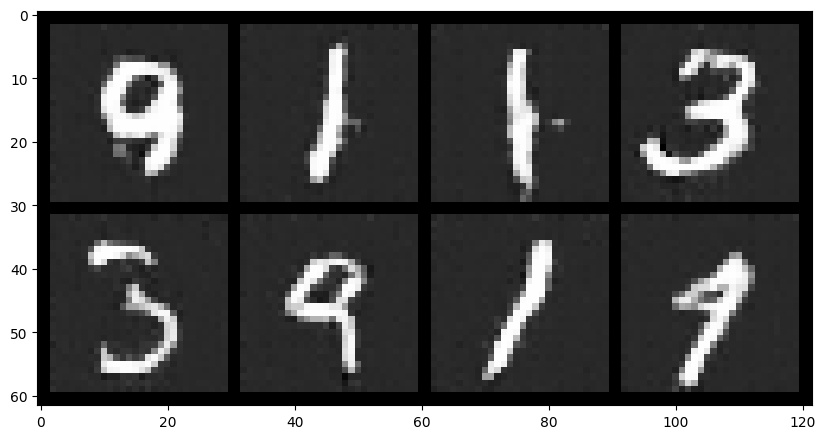

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5520] [G loss: 1.3884]


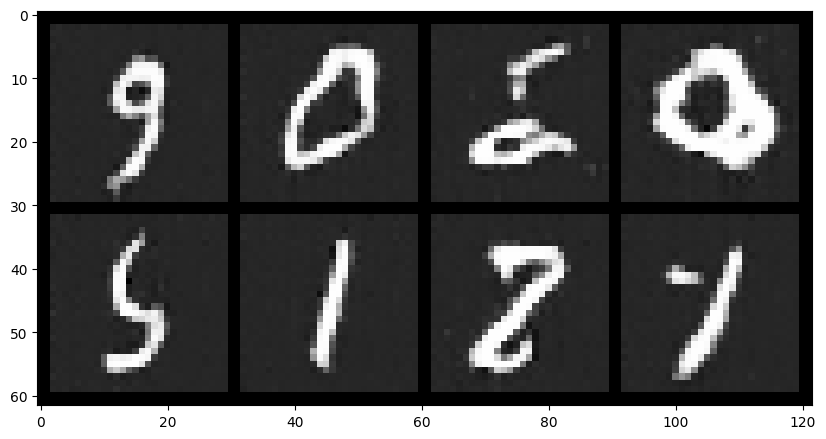

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5935] [G loss: 0.9398]


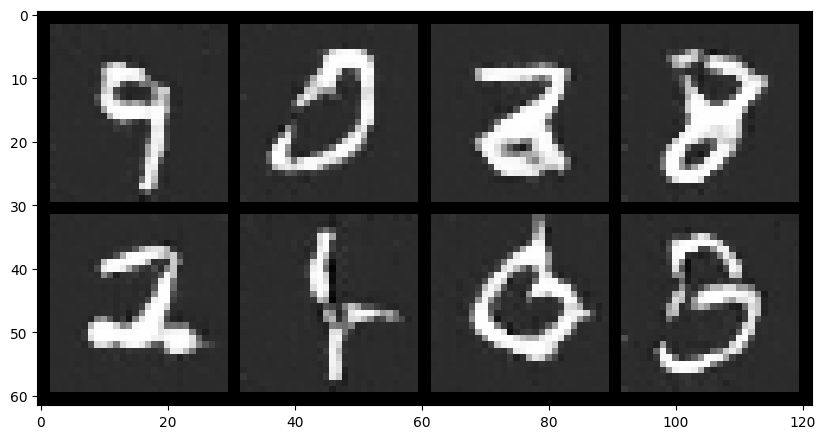

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6184] [G loss: 1.0558]


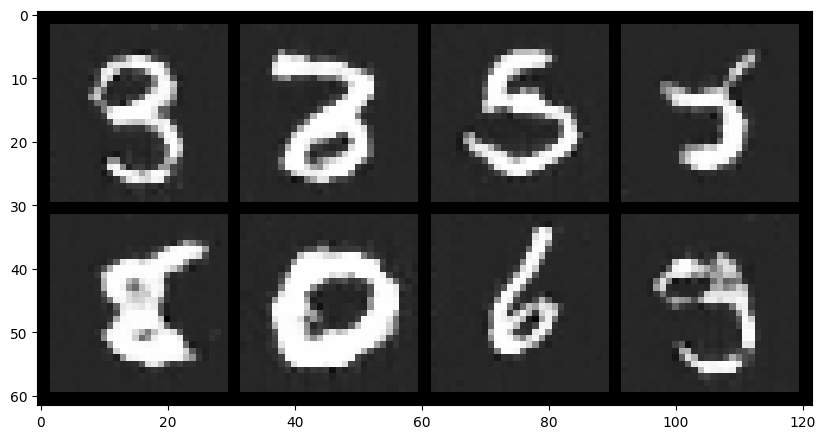

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.5913] [G loss: 0.9572]


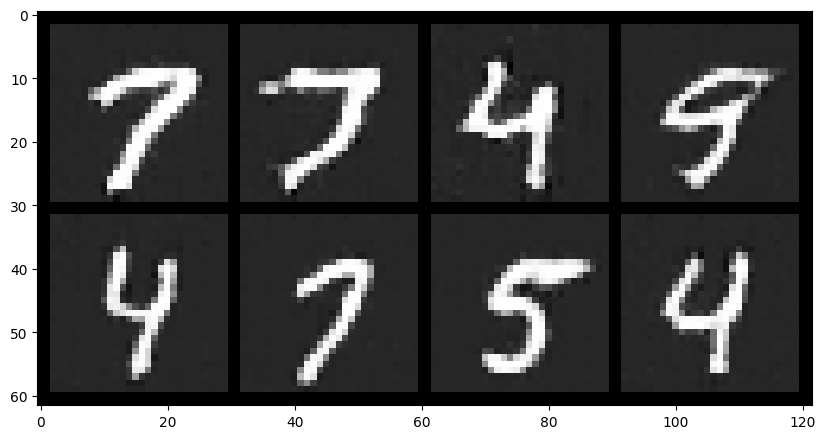

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6037] [G loss: 0.9519]


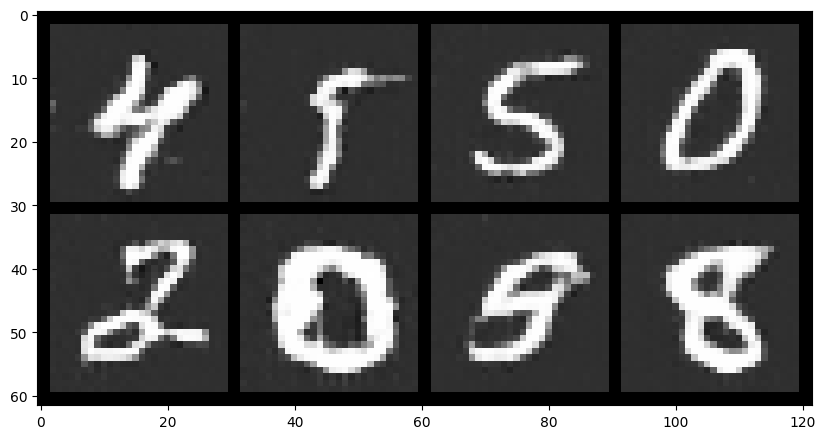

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6275] [G loss: 1.4421]


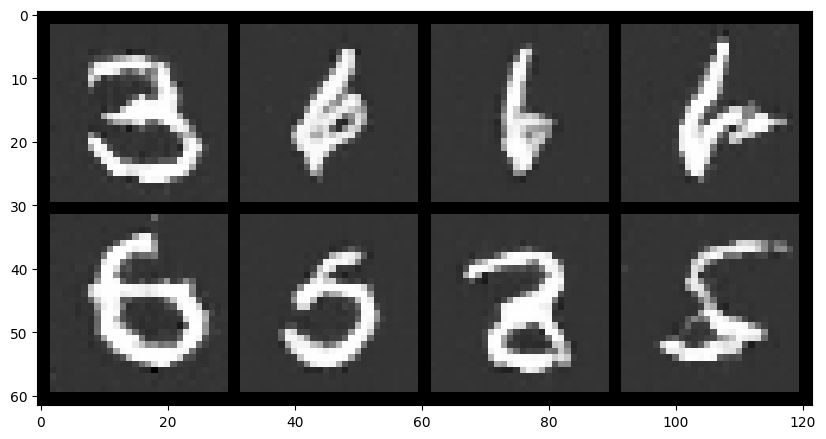

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6917] [G loss: 1.5275]


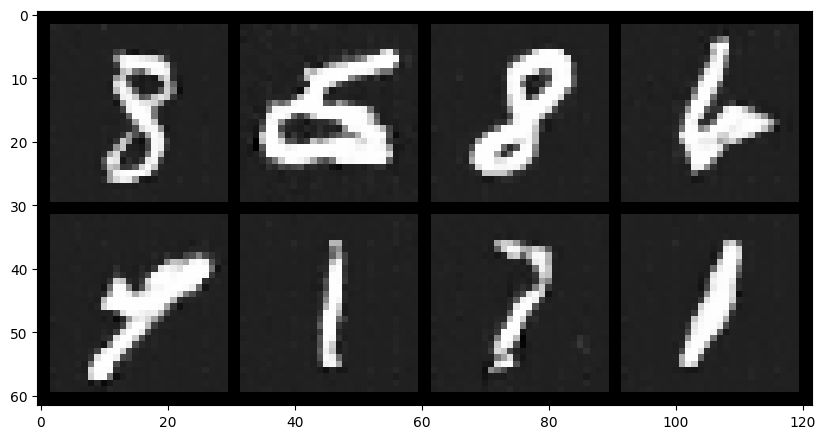

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6968] [G loss: 1.5580]


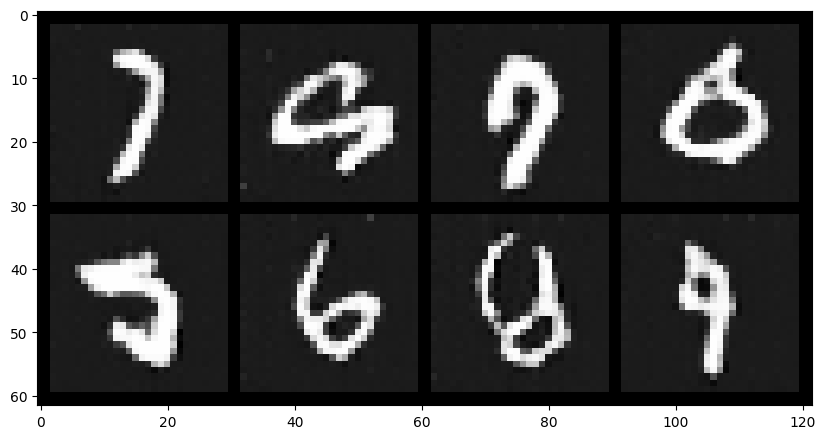

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6266] [G loss: 1.0584]


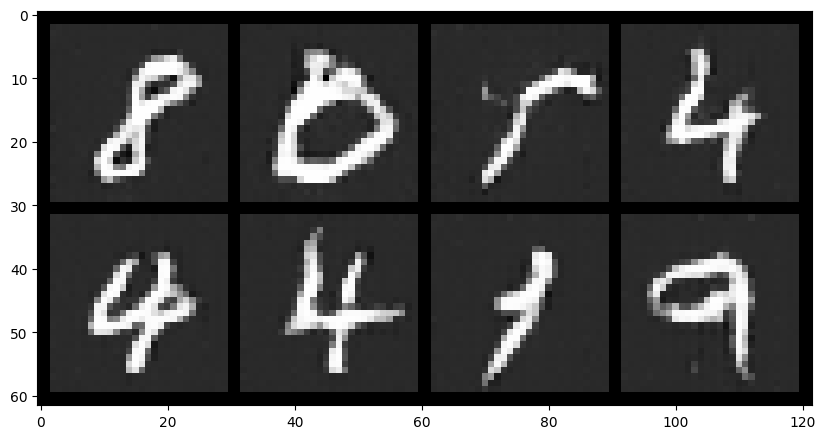

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.7641] [G loss: 1.7150]


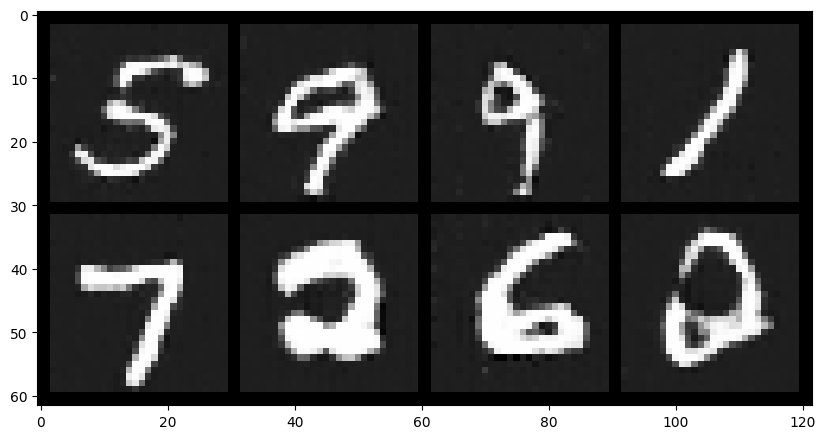

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6673] [G loss: 1.1216]


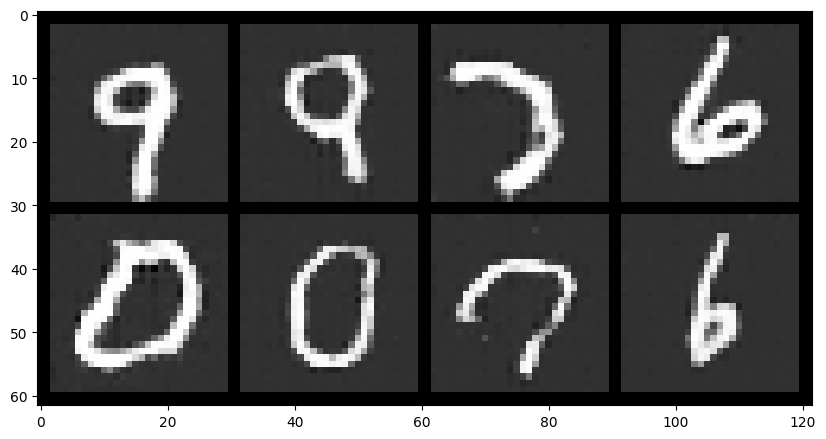

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.7115] [G loss: 1.6498]


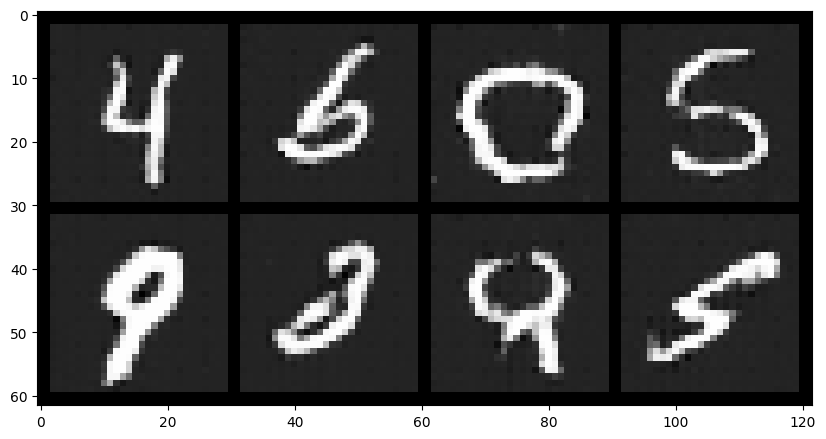

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.1101] [G loss: 2.7467]


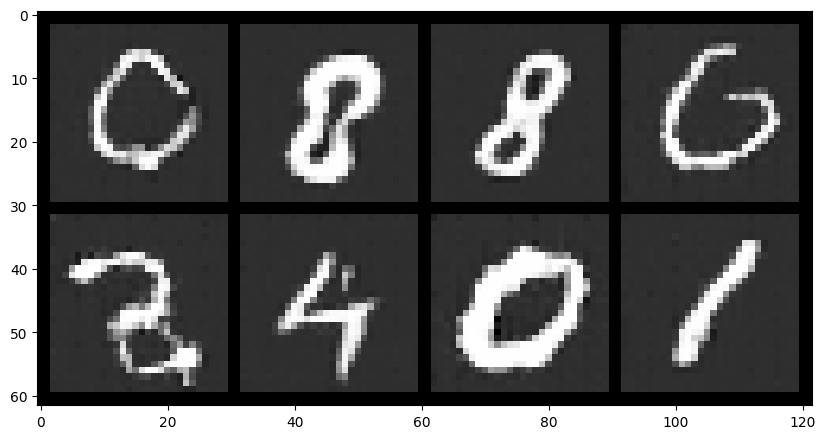

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.7400] [G loss: 1.5483]


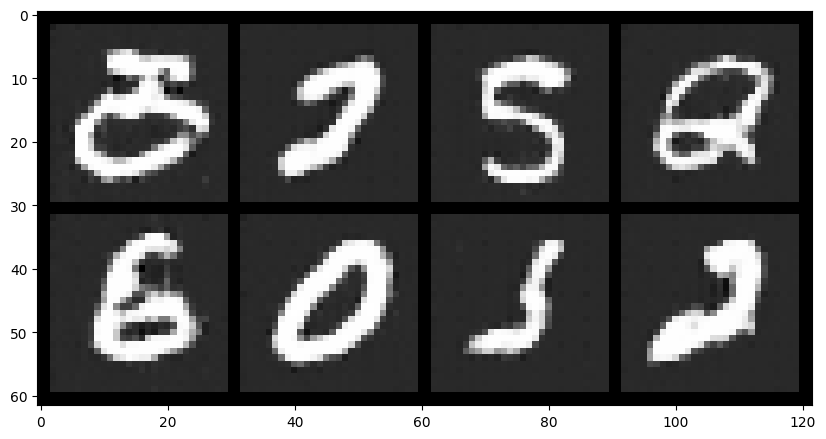

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 0.6239] [G loss: 1.2009]


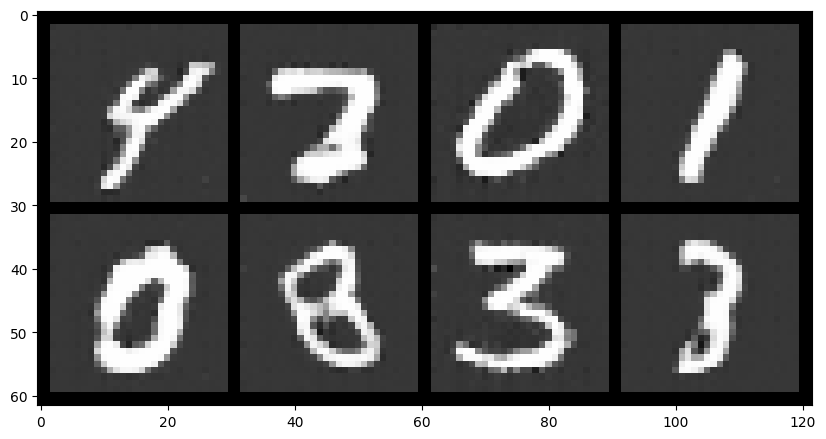

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Validation avg loss] ----- [D loss: 1.5027] [G loss: 3.6777]


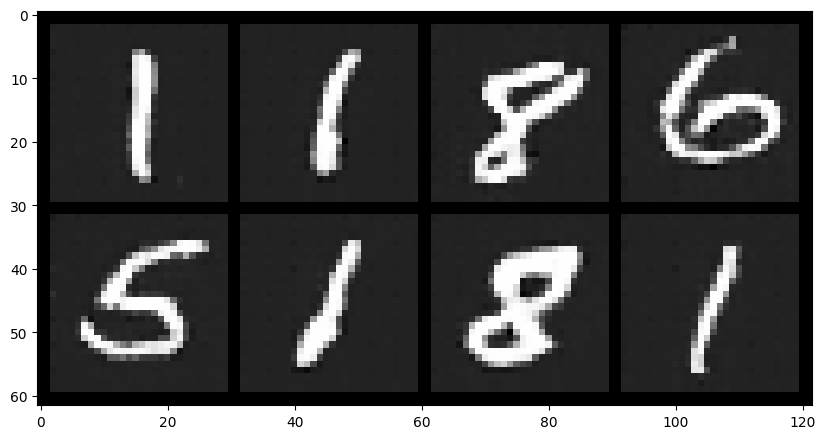

In [ ]:
generator, discriminator, val_gen_losses, val_dis_losses = train_gan(train_loader, val_loader, latent_dim, num_epochs=20)

In [ ]:
torch.save(generator.state_dict(), data_path+'gen_model.pth')
torch.save(discriminator.state_dict(), data_path+'dis_model.pth')

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [14]:
!unzip '/content/models.zip' -d '/content/'

Archive:  /content/models.zip
  inflating: /content/gen_model.pth  
  inflating: /content/vae_model.pth  
  inflating: /content/dis_model.pth  


In [30]:
# load the vae model
input_dim = 784
hidden_dim = 256
latent_dim = 10

vae = VAE(input_dim, hidden_dim, latent_dim)
vae.load_state_dict(torch.load(data_path + 'vae_model.pth'))
vae = vae.to(DEVICE)

In [31]:
latent_dim = 100
img_shape=(1, 28, 28)
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

generator.load_state_dict(torch.load(data_path + 'gen_model.pth'))
generator = generator.to(DEVICE)
discriminator.load_state_dict(torch.load(data_path + 'dis_model.pth'))
discriminator = discriminator.to(DEVICE)

--- Comparing Generated Images ---


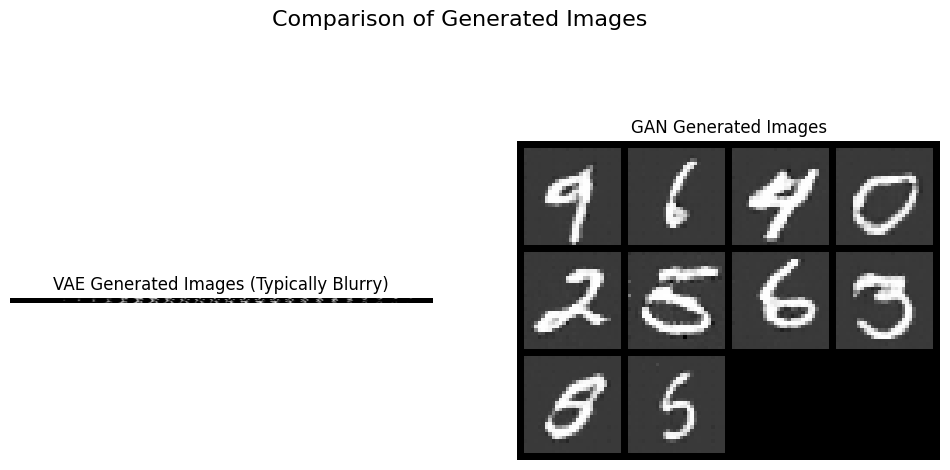

In [32]:

# Assuming you have these variables from the training sections:
# vae_model, val_losses_vae
# gan_generator, gan_discriminator, val_gen_losses_gan, val_dis_losses_gan
# latent_dim

# TODO
# Comparison of the generated images

# --- 1. Visual Comparison of Generated Images ---

print("--- Comparing Generated Images ---")

# Set the number of images to generate for the comparison
num_images_to_show = 10

# Set models to evaluation mode
vae.eval()
generator.eval()

# Generate images from the VAE
with torch.no_grad():
    # Sample random noise from the prior distribution (standard normal)
    z_vae = torch.randn(num_images_to_show, 10).to(DEVICE)
    # Generate images by passing noise through the VAE's decoder
    vae_generated_images = vae.decoder(z_vae)

# Generate images from the GAN
with torch.no_grad():
    # Sample random noise
    z_gan = torch.randn(num_images_to_show, 100).to(DEVICE)
    # Generate images using the GAN's generator
    gan_generated_images = generator(z_gan)

# Create grids of images for display
# normalize=True scales the image pixel values to the [0, 1] range for visualization
vae_grid = torchvision.utils.make_grid(vae_generated_images, nrow=4, normalize=True)
gan_grid = torchvision.utils.make_grid(gan_generated_images, nrow=4, normalize=True)

# Plot the grids side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison of Generated Images', fontsize=16)

# VAE Plot
axes[0].imshow(vae_grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axes[0].set_title('VAE Generated Images (Typically Blurry)')
axes[0].axis('off')

# GAN Plot
axes[1].imshow(gan_grid.cpu().permute(1, 2, 0))
axes[1].set_title('GAN Generated Images')
axes[1].axis('off')

plt.show()



In [33]:
def plot(losses, title):
  # TODO
  """
  Plots the loss curves. Can handle a single loss curve (for VAE)
  or two loss curves (for GAN).

  Args:
      losses (list or tuple): A list of loss values, or a tuple of two lists
                              (e.g., for Generator and Discriminator losses).
      title (str): The title for the plot.
  """
  plt.figure(figsize=(10, 5))

  # Check if we are plotting GAN losses (Generator and Discriminator)
  if isinstance(losses, tuple) and len(losses) == 2:
      plt.plot(losses[0], label='Generator Loss')
      plt.plot(losses[1], label='Discriminator Loss')
      plt.ylabel('Loss')
  # Otherwise, plot a single loss curve (for VAE)
  else:
      plt.plot(losses, label='Validation Loss')
      plt.ylabel('Validation Loss')

  plt.xlabel('Epochs')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

## **VAE**

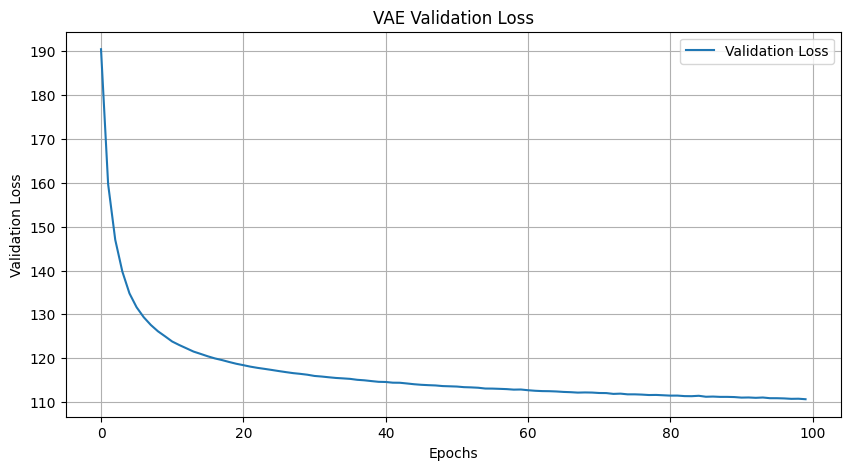

In [ ]:
# VAE validation loss plot
plot(losses=vae_val_loss, title='VAE Validation Loss')

In [42]:
# TODO
# Define VAE and load pre-trained weights in eval mode
input_dim = 784
hidden_dim = 256
latent_dim = 10

vae = VAE(input_dim, hidden_dim, latent_dim)
vae.load_state_dict(torch.load(data_path + 'vae_model.pth'))
vae = vae.to(DEVICE)
vae.eval()

VAE(
  (encoder): Encoder(
    (FC_input): Linear(in_features=784, out_features=256, bias=True)
    (FC_mean): Linear(in_features=256, out_features=10, bias=True)
    (FC_log_var): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (FC_hidden): Linear(in_features=10, out_features=256, bias=True)
    (FC_output): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [38]:
def VAElatentSamplegeneration(model, num=64):
  # TODO
  # Sample x from distribution and generate images
  model.eval()
  with torch.no_grad():
    latent_dim = model.encoder.FC_mean.out_features
    x = torch.randn(num, latent_dim).to(DEVICE)
    samples = model.decoder(x)
    samples = samples.view(num, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(samples, nrow=8)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

  return samples

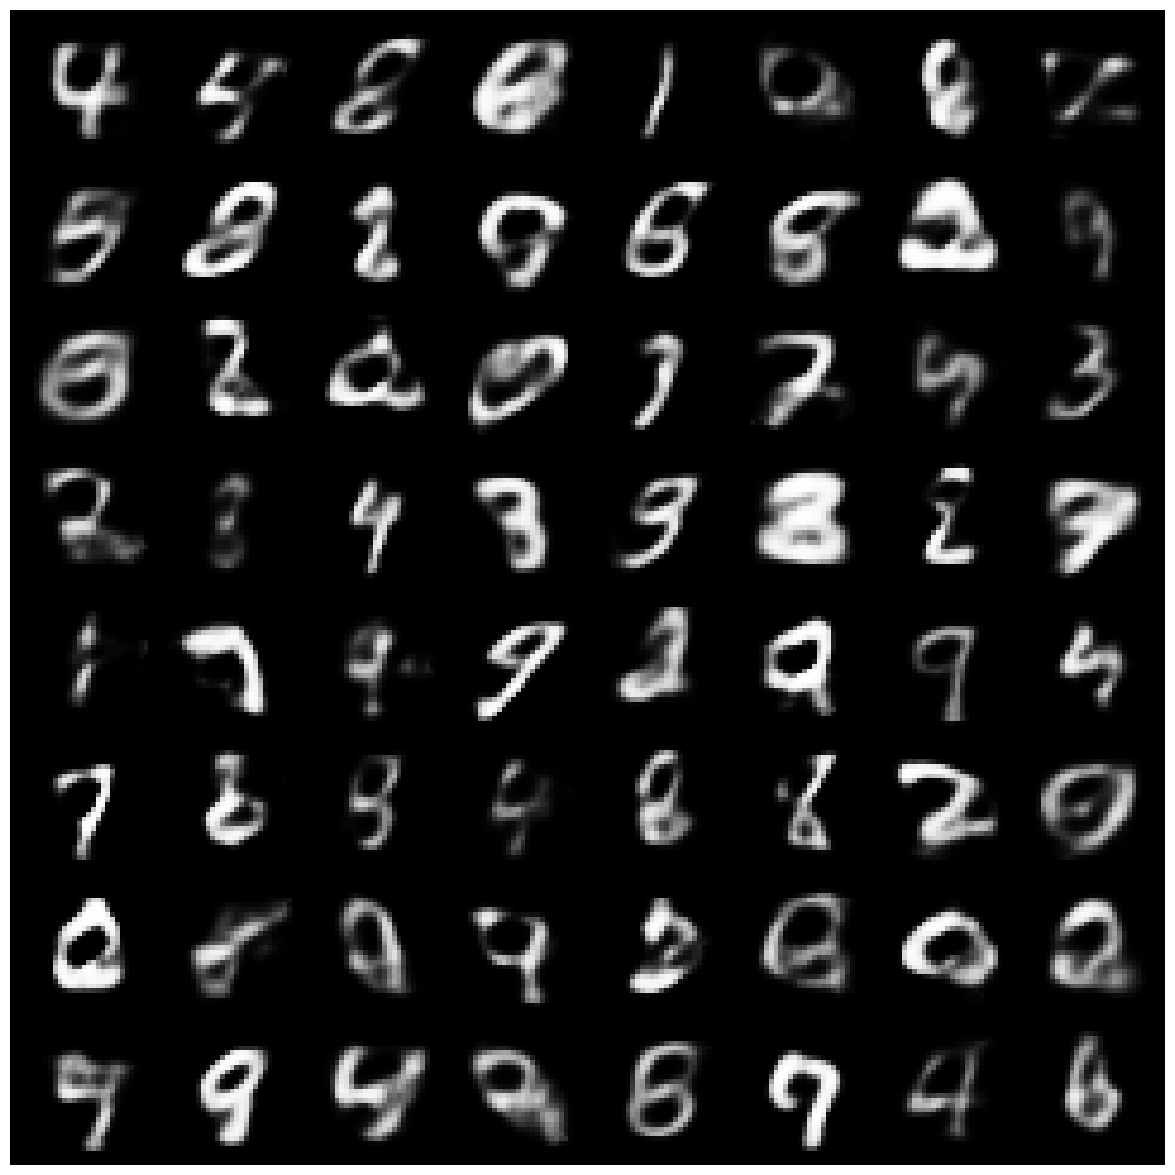

tensor([[[[7.8136e-18, 5.7823e-18, 7.2365e-18,  ..., 4.0293e-18,
           1.8308e-18, 4.8107e-18],
          [1.7033e-17, 6.8690e-18, 1.8296e-18,  ..., 8.2972e-18,
           3.5818e-18, 5.5356e-18],
          [4.5690e-18, 2.1079e-18, 1.0309e-27,  ..., 3.1302e-33,
           5.7476e-18, 2.7986e-18],
          ...,
          [3.5120e-18, 1.3218e-17, 8.0959e-09,  ..., 7.5549e-07,
           1.2399e-23, 5.1833e-18],
          [7.1584e-18, 6.6833e-18, 9.6071e-18,  ..., 4.7892e-37,
           1.0992e-17, 3.5017e-18],
          [2.9298e-18, 9.2355e-18, 3.6577e-18,  ..., 3.0865e-18,
           3.5711e-18, 1.2611e-18]]],


        [[[1.2545e-17, 6.2852e-17, 2.0512e-17,  ..., 3.2721e-18,
           1.5472e-17, 2.3613e-18],
          [3.6928e-17, 2.5805e-17, 1.1494e-17,  ..., 2.5417e-17,
           1.7098e-17, 1.7185e-17],
          [2.4364e-17, 1.5234e-17, 3.4796e-28,  ..., 2.3894e-16,
           6.7545e-18, 1.0994e-17],
          ...,
          [2.1422e-17, 2.6683e-17, 8.8283e-21,  ..., 1.45

In [39]:
VAElatentSamplegeneration(vae)

## **GAN**

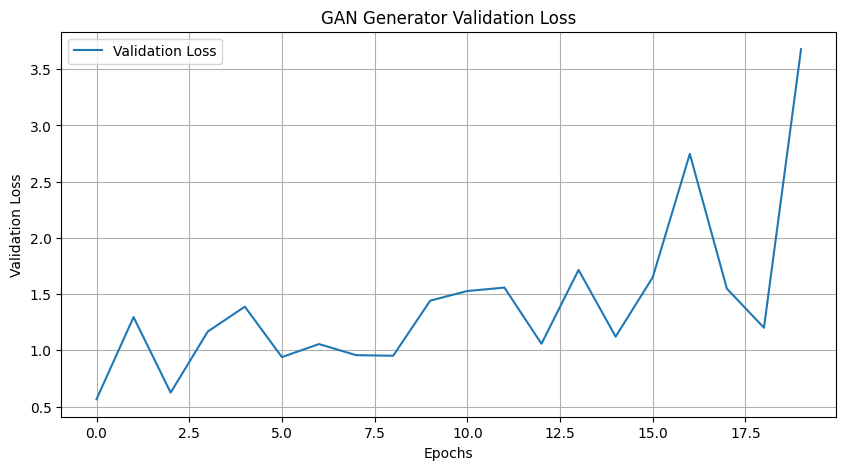

In [ ]:
# GAN Generator validation loss plot
plot(losses=val_gen_losses, title='GAN Generator Validation Loss')

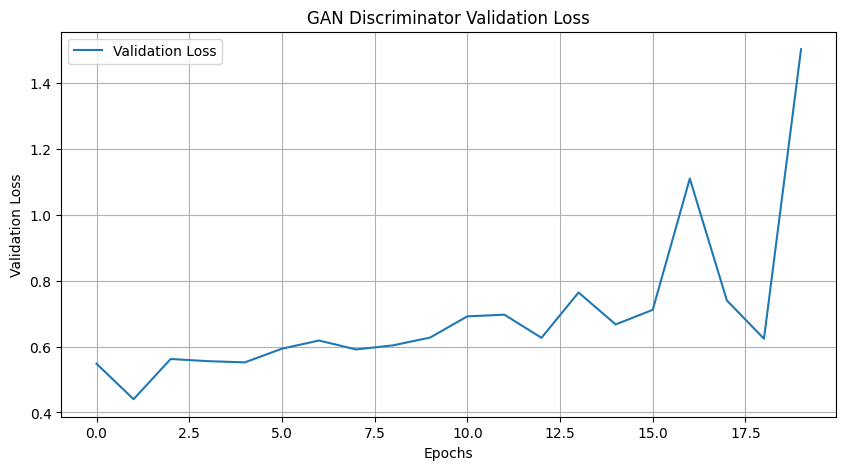

In [ ]:
# GAN Discriminator validation loss plot
plot(losses=val_dis_losses, title='GAN Discriminator Validation Loss')

In [43]:
# TODO
# Define generator and load pre-trained weights in eval mode
generator = Generator(latent_dim, img_shape)

generator.load_state_dict(torch.load(data_path + 'gen_model.pth'))
generator = generator.to(DEVICE)
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=6272, bias=True)
    (7): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2

In [46]:
def GANlatentSamplegeneration(model, num=64):
  # TODO
  # Sample noise and genrate images using generator
  model.eval()
  with torch.no_grad():
    latent_dim = model.model[0].in_features
    x = torch.randn(num, latent_dim).to(DEVICE)
    samples = model(x)
    grid_img = torchvision.utils.make_grid(samples, nrow=8, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

  return samples

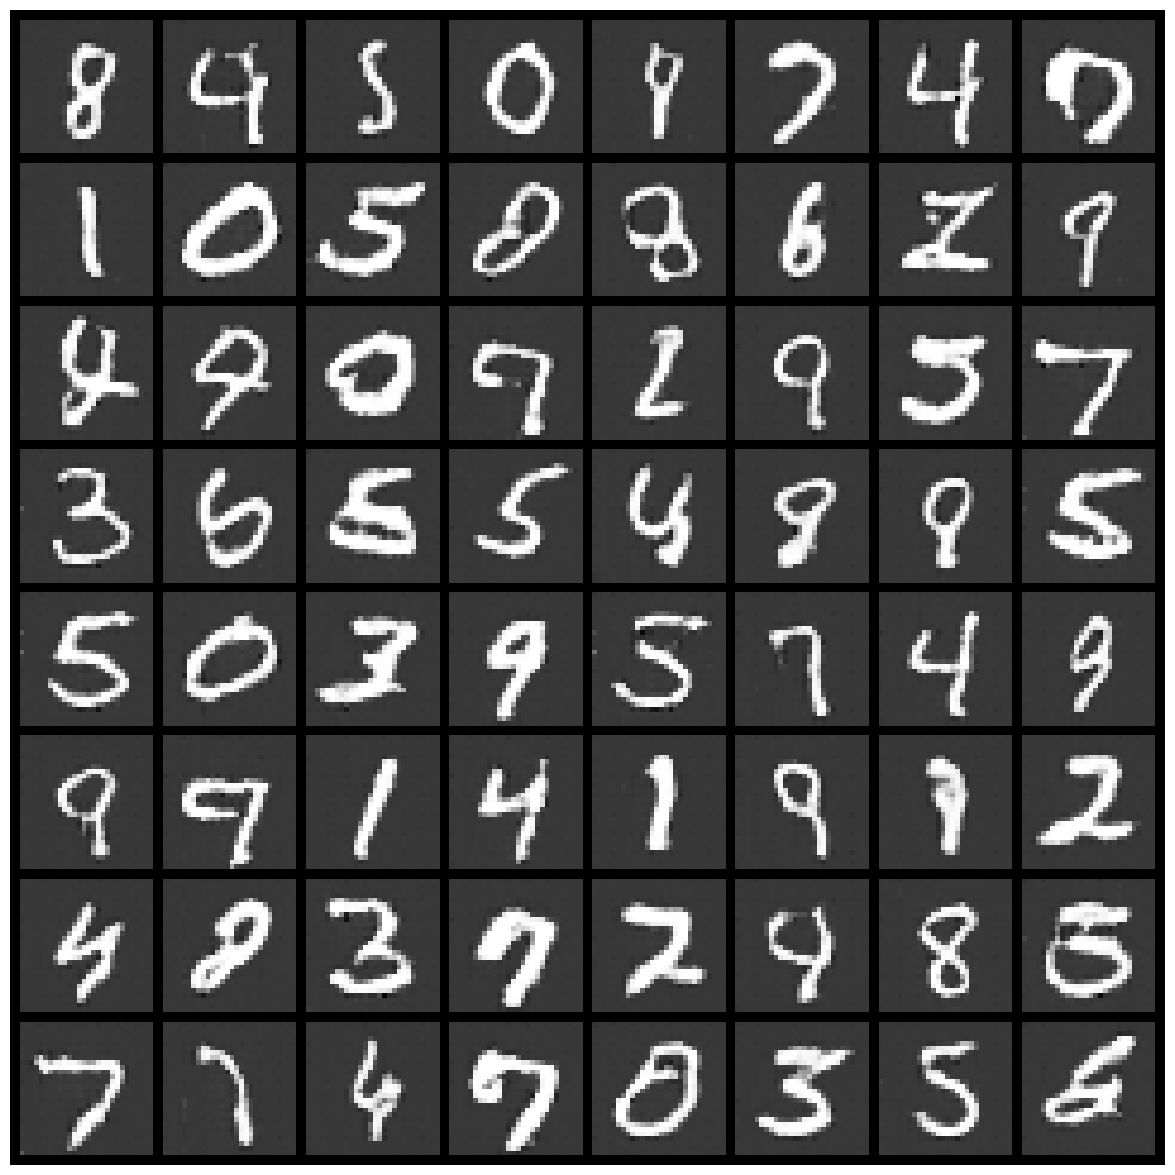

tensor([[[[-3.5931e-03,  6.5582e-03, -1.9697e-03,  ...,  8.2399e-03,
           -5.5104e-03, -1.4575e-03],
          [ 5.5487e-04,  4.3596e-03,  1.9352e-03,  ...,  2.1543e-03,
            2.0352e-03,  8.8339e-04],
          [-1.4470e-03,  2.9494e-03,  1.8604e-03,  ...,  4.9972e-04,
            1.7045e-03,  6.6906e-04],
          ...,
          [ 2.1379e-04,  9.8489e-04,  1.4908e-03,  ...,  2.2943e-03,
            1.2497e-03,  2.3142e-03],
          [-9.6860e-04,  9.4236e-04, -5.3486e-04,  ...,  1.0907e-03,
            2.0441e-03,  3.4466e-03],
          [-6.5872e-03,  1.7421e-03,  1.1683e-04,  ...,  1.6395e-03,
            8.4614e-04,  2.6573e-03]]],


        [[[ 3.8540e-04,  1.1061e-02, -3.7458e-03,  ..., -4.2077e-03,
            4.5833e-03, -1.7099e-03],
          [-4.1341e-03,  2.0412e-03,  6.5936e-03,  ...,  5.6320e-03,
           -6.2433e-04,  3.0222e-03],
          [ 2.8404e-03,  4.2311e-03,  7.8622e-04,  ...,  1.1671e-04,
            3.0155e-03, -1.1440e-03],
          ...,
   

In [47]:
GANlatentSamplegeneration(generator, num=64)

## Evaluate with GAN discriminator

In [48]:
# load discriminator
img_shape=(1, 28, 28)
discriminator = Discriminator(img_shape)
discriminator.load_state_dict(torch.load(data_path + 'dis_model.pth'))
discriminator = discriminator.to(DEVICE)


In [55]:
def discriminatorEvaluation(model, generated_samples):
  model.eval()
  pred_validation = model(generated_samples)

  is_classified_as_real = pred_validation > 0
  is_classified_as_real_cpu = is_classified_as_real.cpu()

  num_valid = np.count_nonzero(is_classified_as_real_cpu)

  total_samples = pred_validation.shape[0]

  return num_valid / total_samples

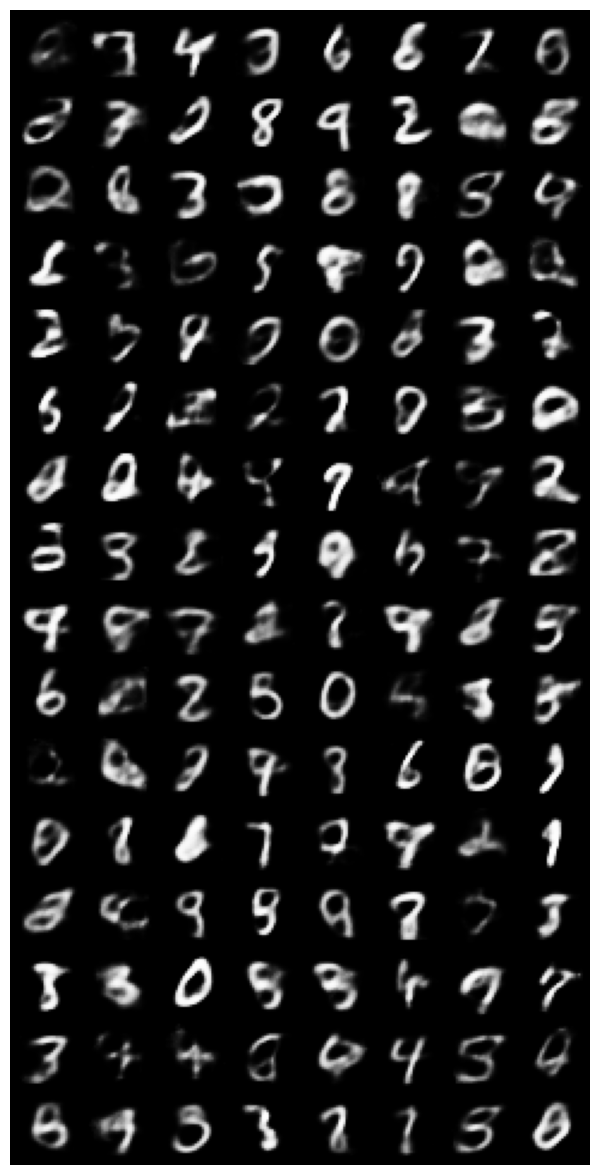

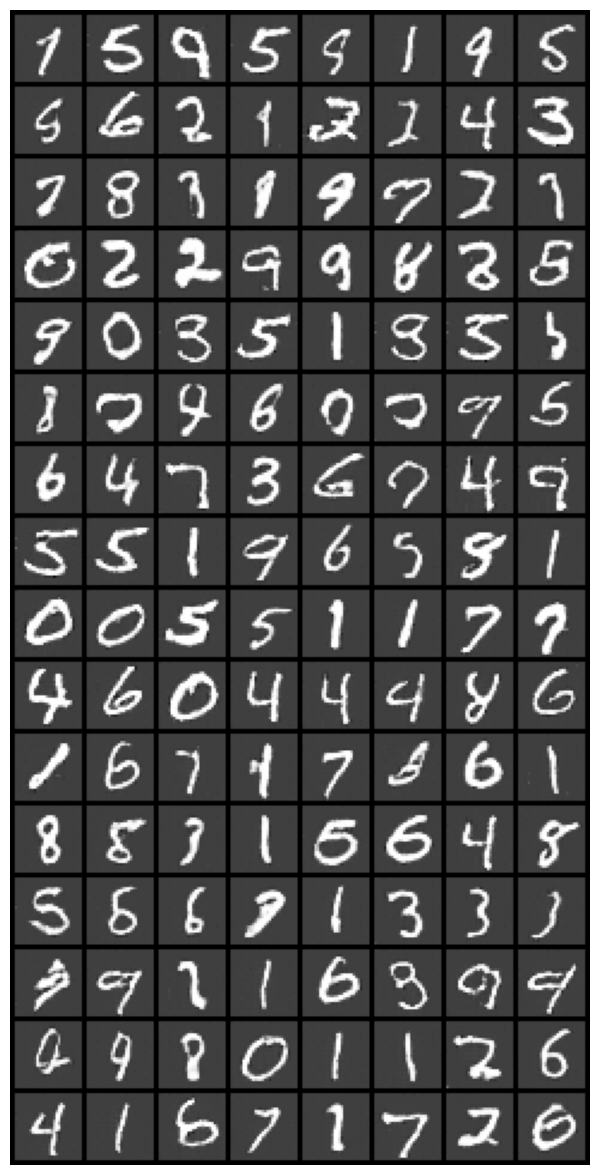

In [50]:
vae_generated_samples = VAElatentSamplegeneration(vae.to('cuda'), num=128)
gan_generated_samples = GANlatentSamplegeneration(generator.to('cuda'), num=128)

In [51]:
vae_generated_samples.shape, gan_generated_samples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

In [57]:
print(f'percentage of valid generated image to all for GAN model: {discriminatorEvaluation(discriminator, gan_generated_samples)}')
print(f'percentage of valid generated image to all for VAE model: {discriminatorEvaluation(discriminator, vae_generated_samples)}')

ercentage of valid generated image to all for GAN model: 0.2012235
percentage of valid generated image to all for VAE model: 0.2532149
